In [2040]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re

from sklearn.preprocessing import LabelEncoder


import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2042]:
df = pd.read_csv("../data/listings.csv", sep = ",")

## Data Cleaning

### [price] Dropping listings without price

In [2045]:
df.price.isna().sum()

972

In [2046]:
df = df.dropna(subset = "price")

### [price] Converting to Numeric Values

In [2049]:
# Price
df["price"] = df["price"].apply(lambda x: float(x[1:].replace(",","")) if pd.notna(x) else x)

In [2051]:
df.price.describe()

count     33692.000000
mean        731.188235
std        5667.250477
min           0.000000
25%         199.000000
50%         307.000000
75%         572.000000
max      633125.000000
Name: price, dtype: float64

In [2054]:
df.describe().price

count     33692.000000
mean        731.188235
std        5667.250477
min           0.000000
25%         199.000000
50%         307.000000
75%         572.000000
max      633125.000000
Name: price, dtype: float64

In [2055]:
df = df.loc[df.price > 0, :]

### Host Features

In [2061]:
re_host = "host.*"

host_feat = []

for feat in df.columns:
    if re.match(re_host, feat):
         host_feat.append(feat)

host_drop = ["host_id", "host_url", "host_name", "host_location", "host_about", "host_thumbnail_url", 
             "host_picture_url", "host_neighbourhood", "host_since", "host_listings_count", "host_total_listings_count"]

df = df.drop(host_drop, axis = 1)

### Id Features

In [2063]:
re_id = ".*id.*"

id_feat = []

for feat in df.columns:
    if re.match(re_id, feat):
         id_feat.append(feat)

id_drop = ["id", "scrape_id"]

df = df.drop(id_drop, axis = 1)

### Url features

In [2066]:
re_url = ".*url.*"

url_feat = []

for feat in df.columns:
    if re.match(re_url, feat):
        url_feat.append(feat)
        
url_drop = ["listing_url", "picture_url"]

df = df.drop(url_drop, axis = 1)

### Others to drop

In [2069]:
## Majority missing values
feat_na = df.isna().sum()

print(feat_na[feat_na > 0].sort_values(ascending = False))

nas_drop = ["calendar_updated", "license", "neighbourhood_group_cleansed", "neighbourhood", "neighborhood_overview"]
df = df.drop(nas_drop, axis = 1)

calendar_updated                33691
license                         33691
neighbourhood_group_cleansed    33691
neighbourhood                   17122
neighborhood_overview           17122
review_scores_value              8100
review_scores_location           8098
review_scores_communication      8098
review_scores_checkin            8098
review_scores_cleanliness        8098
review_scores_accuracy           8098
first_review                     8089
review_scores_rating             8089
last_review                      8089
reviews_per_month                8089
host_response_rate               5605
host_response_time               5605
host_acceptance_rate             3431
description                      1129
host_is_superhost                 833
has_availability                  292
bathrooms_text                     39
bedrooms                           38
beds                               24
bathrooms                          23
dtype: int64


In [2072]:
feat_not_relevant = ["last_scraped", "source", "first_review", "last_review", "name", "description",
                    "calculated_host_listings_count", "calculated_host_listings_count_entire_homes",
                    "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "calendar_last_scraped"]

# neighbourhood is better represented in neighbourhood_cleansed
df = df.drop(feat_not_relevant, axis = 1)

# EDA

In [2075]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33691 entries, 0 to 34663
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           28086 non-null  object 
 1   host_response_rate           28086 non-null  object 
 2   host_acceptance_rate         30260 non-null  object 
 3   host_is_superhost            32858 non-null  object 
 4   host_verifications           33691 non-null  object 
 5   host_has_profile_pic         33691 non-null  object 
 6   host_identity_verified       33691 non-null  object 
 7   neighbourhood_cleansed       33691 non-null  object 
 8   latitude                     33691 non-null  float64
 9   longitude                    33691 non-null  float64
 10  property_type                33691 non-null  object 
 11  room_type                    33691 non-null  object 
 12  accommodates                 33691 non-null  int64  
 13  bathrooms            

### Outliers (numerical)

In [2078]:
# Numerical
df_numerical = df.select_dtypes(exclude = 'object')
df_numerical.iloc[:, 0:15].describe()

latitude     longitude  accommodates     bathrooms      bedrooms  \
count  33691.000000  33691.000000  33691.000000  33668.000000  33653.000000   
mean     -22.967648    -43.248490      4.014455      1.551934      1.554156   
std        0.034586      0.099623      2.338395      1.007678      1.047949   
min      -23.073276    -43.723009      1.000000      0.000000      0.000000   
25%      -22.984630    -43.302590      2.000000      1.000000      1.000000   
50%      -22.972960    -43.194271      4.000000      1.000000      1.000000   
75%      -22.956846    -43.185430      5.000000      2.000000      2.000000   
max      -22.749950    -43.104400     16.000000     29.000000     30.000000   

               beds          price  minimum_nights  maximum_nights  \
count  33667.000000   33691.000000    33691.000000    33691.000000   
mean       2.273621     731.209937        3.609955      418.070226   
std        2.099932    5667.333185       13.741691      414.065000   
min        0.000000      33.000000        1.000000        1.000000   
25%        1.000000     199.000000        1.000000       60.000000   
50%        2.000000     307.000000        2.000000      365.000000   
75%        3.000000     572.000000        3.000000      365.000000   
max       56.000000  633125.000000     1000.000000     1125.000000   

       minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  \
count            33691.000000            33691.000000            33691.000000   
mean                 3.313823                4.238550              514.393102   
std                 11.496802               14.037274              451.971896   
min                  1.000000                1.000000                1.000000   
25%                  1.000000                2.000000               90.000000   
50%                  2.000000                3.000000              365.000000   
75%                  3.000000                4.000000             1125.000000   
max                630.000000             1125.000000             1125.000000   

       maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  
count            33691.000000            33691.000000            33691.000000  
mean               541.720697                3.660158              527.186035  
std                455.819346               12.376279              449.299082  
min                  1.000000                1.000000                1.000000  
25%                 90.000000                1.300000               90.000000  
50%                365.000000                2.000000              365.000000  
75%               1125.000000                3.000000             1125.000000  
max               1125.000000              630.000000             1125.000000

In [2080]:
df_numerical.iloc[:, 15:].describe()

availability_30  availability_60  availability_90  availability_365  \
count     33691.000000     33691.000000     33691.000000      33691.000000   
mean         20.234810        43.838978        66.073788        205.610549   
std          10.940283        19.905304        27.820441        114.707026   
min           0.000000         0.000000         0.000000          0.000000   
25%          11.000000        32.000000        52.000000         90.000000   
50%          26.000000        54.000000        79.000000        193.000000   
75%          29.000000        59.000000        89.000000        322.000000   
max          30.000000        60.000000        90.000000        365.000000   

       number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
count       33691.000000           33691.000000            33691.000000   
mean           22.593749               7.761390                0.568995   
std            44.422735              12.093731                1.149579   
min             0.000000               0.000000                0.000000   
25%             1.000000               0.000000                0.000000   
50%             5.000000               2.000000                0.000000   
75%            24.000000              11.000000                1.000000   
max           674.000000             132.000000               20.000000   

       review_scores_rating  review_scores_accuracy  \
count          25602.000000            25593.000000   
mean               4.802834                4.816552   
std                0.360016                0.356751   
min                0.000000                1.000000   
25%                4.750000                4.780000   
50%                4.920000                4.930000   
75%                5.000000                5.000000   
max                5.000000                5.000000   

       review_scores_cleanliness  review_scores_checkin  \
count               25593.000000           25593.000000   
mean                    4.765509               4.891744   
std                     0.399811               0.281986   
min                     1.000000               1.000000   
25%                     4.690000               4.890000   
50%                     4.900000               5.000000   
75%                     5.000000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  \
count                 25593.000000            25593.000000   
mean                      4.881205                4.865371   
std                       0.296750                0.290990   
min                       1.000000                1.000000   
25%                       4.880000                4.850000   
50%                       5.000000                4.970000   
75%                       5.000000                5.000000   
max                       5.000000                5.000000   

       review_scores_value  reviews_per_month  
count         25591.000000       25602.000000  
mean              4.720408           1.094172  
std               0.403923           1.200897  
min               1.000000           0.010000  
25%               4.650000           0.230000  
50%               4.820000           0.680000  
75%               5.000000           1.550000  
max               5.000000          16.960000

In [2082]:
df_numerical.columns

Index(['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

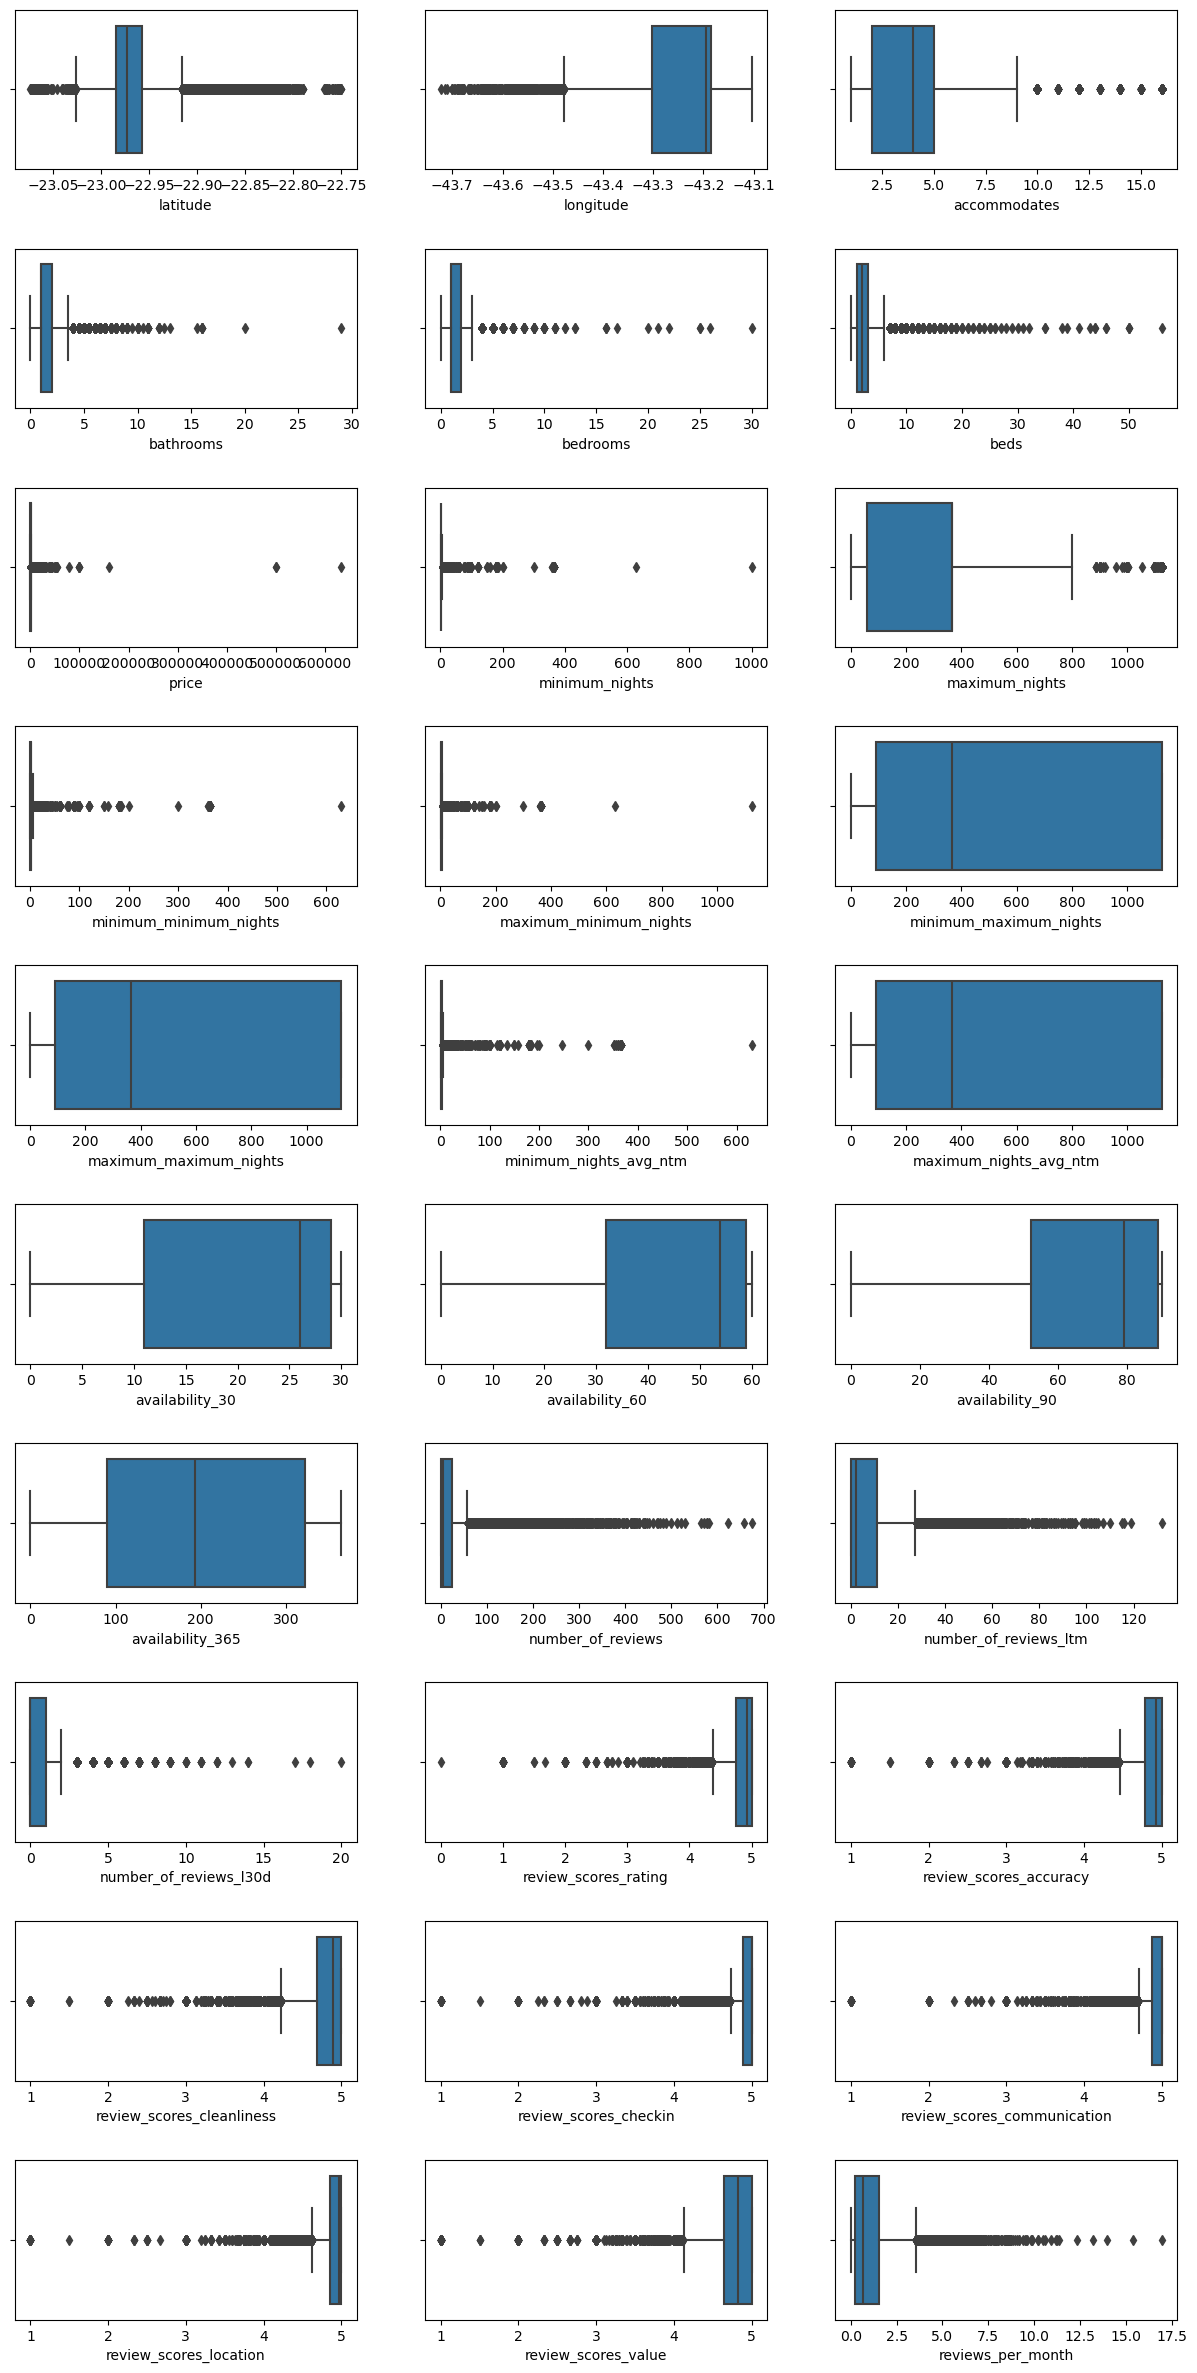

In [2084]:
fig, ax = plt.subplots(nrows = 10, ncols = 3, figsize=(15,30))
fig.subplots_adjust(hspace=0.5)

line = 0
col = 0
index = [0,0]
for feat in df_numerical:        
    #Plot boxplot of current feature
    sns.boxplot(data = df,x = feat, ax = ax[line, col])
        
    #Update index for plotting for the next iteration
    if(col + 1 == 3):
        col = 0
        line += 1
    else:
        col +=1

### [price] Outliers

count     33691.000000
mean        731.209937
std        5667.333185
min          33.000000
25%         199.000000
50%         307.000000
75%         572.000000
max      633125.000000
Name: price, dtype: float64


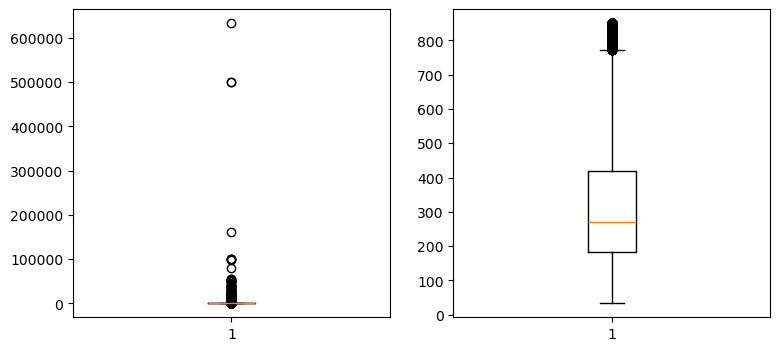

In [2086]:
# Outliers
PRICE_CAP = 850
print(df.price.describe())

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axis[0].boxplot(df.price)
axis[1].boxplot(df.loc[df.price <= PRICE_CAP,:].price)

plt.show()


### TO DO

df.price = df.price.apply(lambda x : x if x < PRICE_CAP else PRICE_CAP)

#df = df.loc[df.price <= PRICE_CAP,:]

### Distribution (categorical)

In [1810]:
df_categorical = df.select_dtypes(include = "object")
df_categorical = df_categorical.drop(["amenities"], axis = 1) #Will de dealt with later
df_categorical.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable'],
      dtype='object')

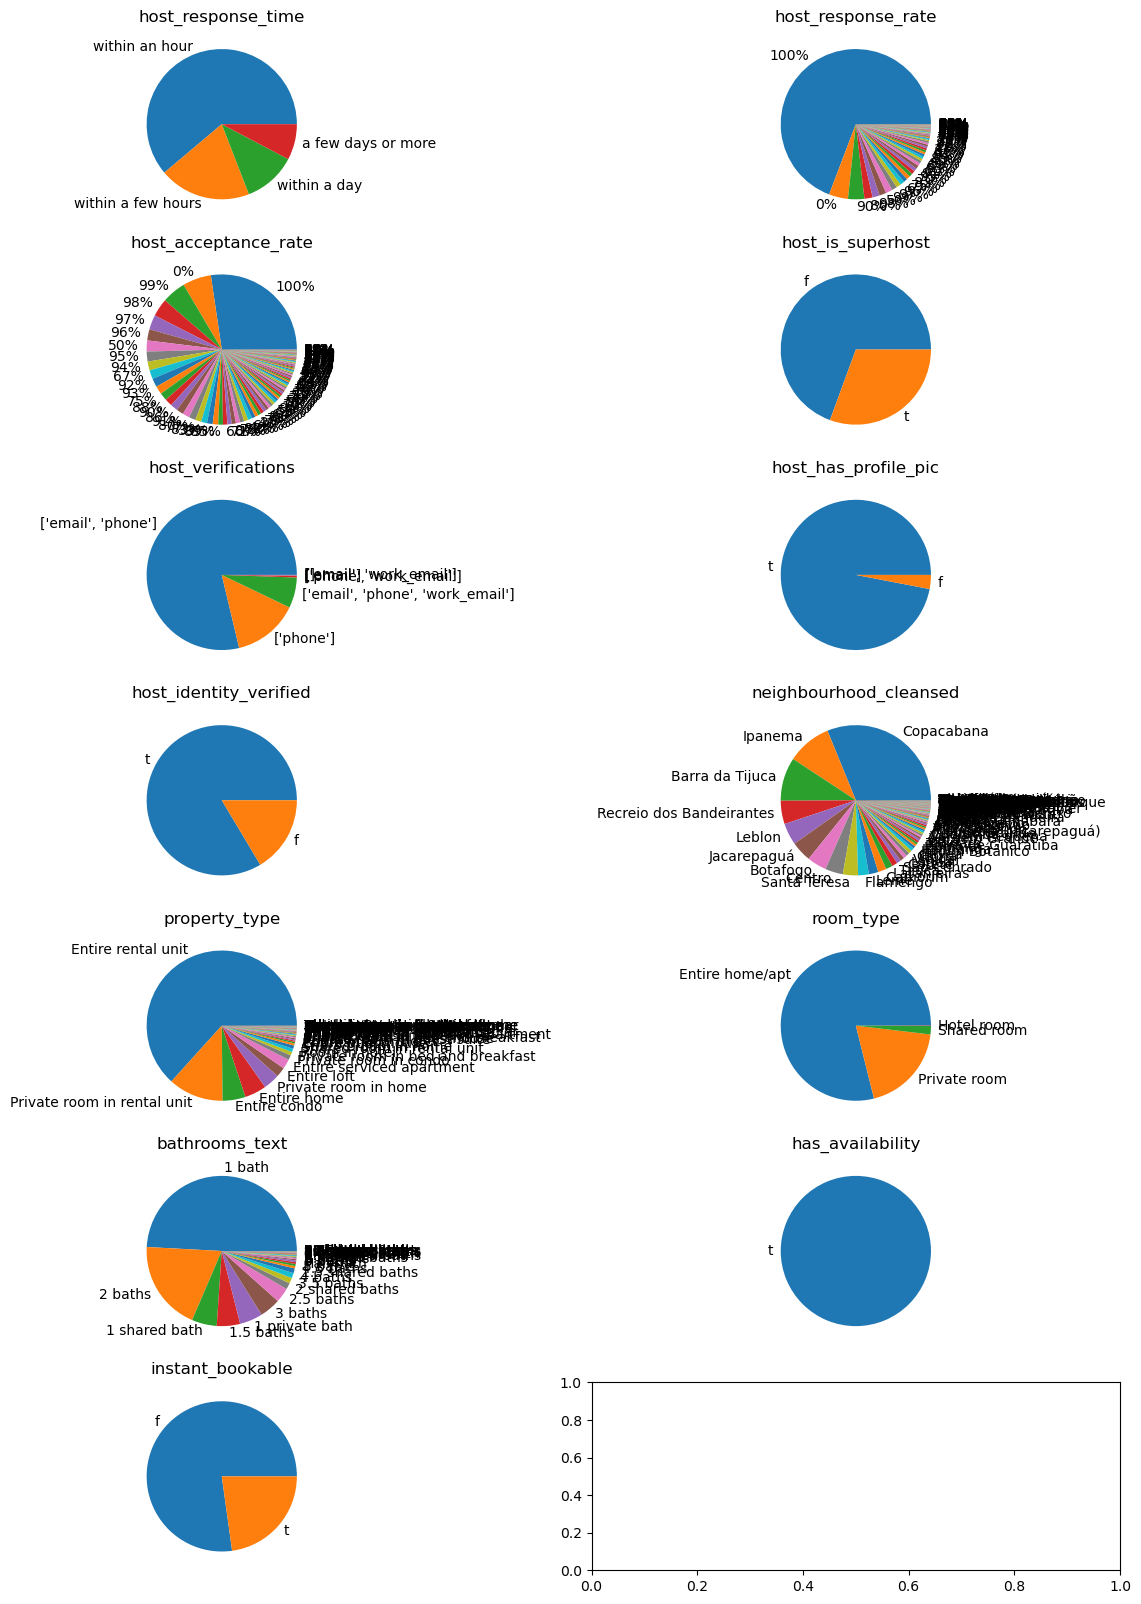

In [1811]:
fig, ax = plt.subplots(nrows = 7, ncols = 2, figsize = (15,20))

line = 0
col = 0

for feat in df_categorical:
    
    ax[line,col].pie(df[feat].value_counts(), labels = df[feat].value_counts().index)
    ax[line,col].title.set_text(feat)
    
    if(col + 1  == 2):
        col = 0
        line += 1
    else:
        col +=1

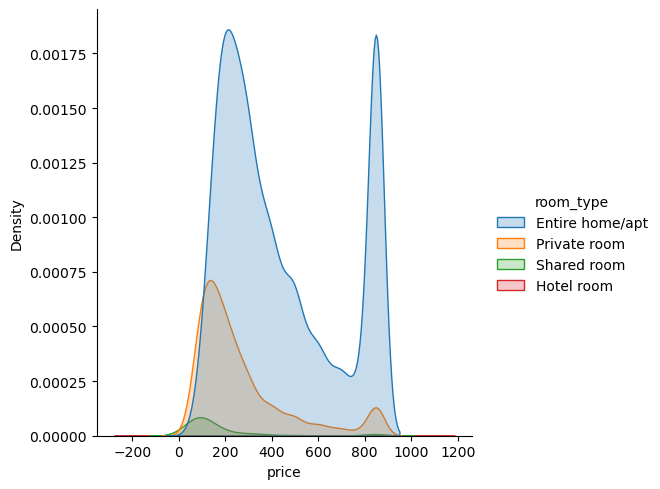

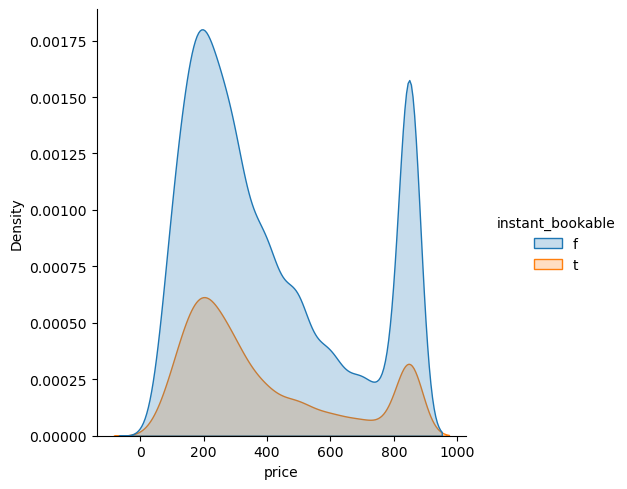

In [1812]:
sns.displot(df, x = "price", hue = "room_type", kind = "kde", fill = "True")
sns.displot(df, x = "price", hue = "instant_bookable", kind = "kde", fill = "True")



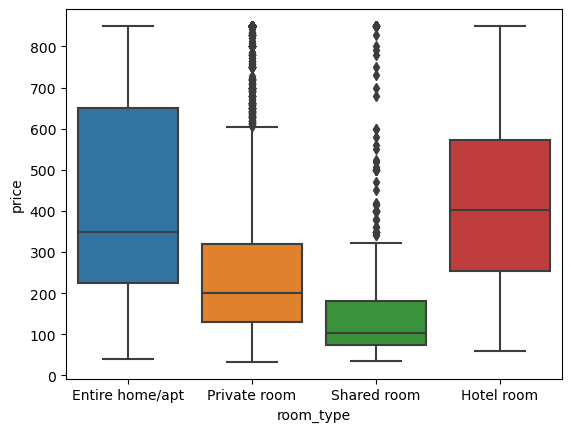

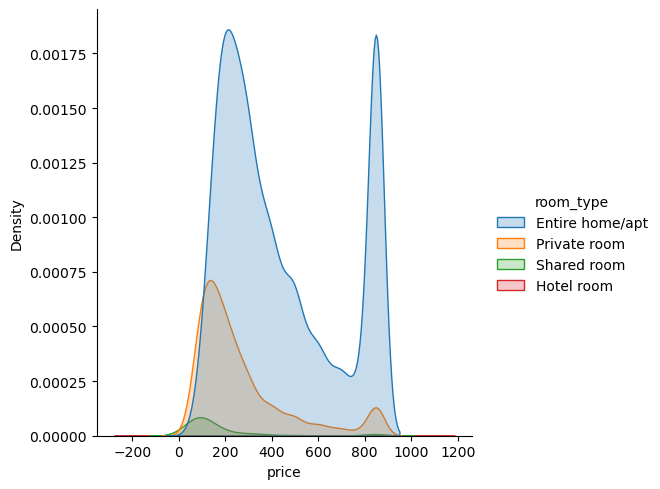

In [1813]:
#Checking skeweness
sns.boxplot(data = df, x = df["room_type"], y=df.price)

# Distribution of Data
sns.displot(df, x = "price", hue = "room_type", kind = "kde", fill = "True")

#sns.displot(penguins, x="flipper_length_mm", hue="species", kind="kde")

<Axes: xlabel='accommodates', ylabel='price'>

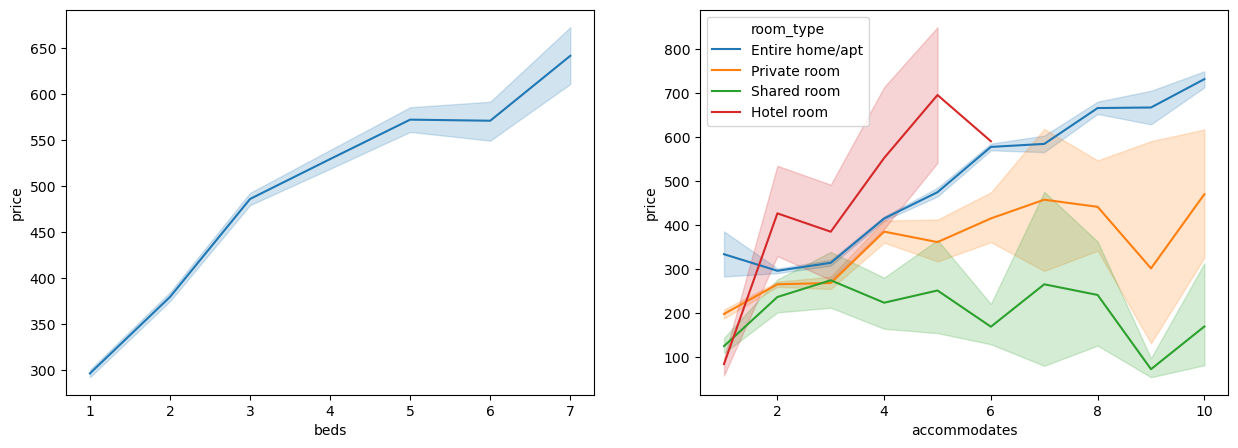

In [1814]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# Min 1 bed and max 7 beds
sns.lineplot(ax =ax[0] , data = df.loc[(df.beds <=7) & (df.beds > 0),:], x="beds", y="price")

# Min 1 ppl and max 10 ppl
sns.lineplot(ax = ax[1], data = df.loc[(df.accommodates <=10) & (df.accommodates > 0),:], x="accommodates", y="price", hue = "room_type")

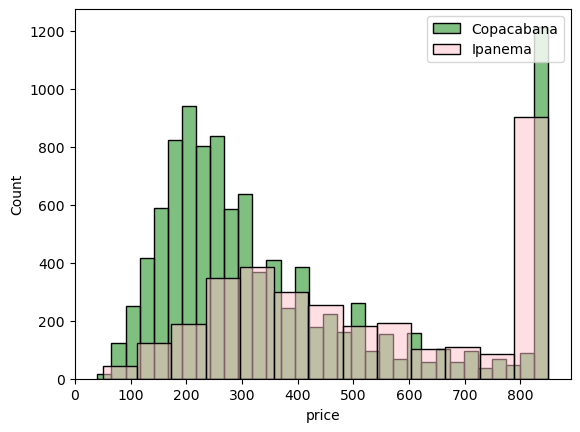

In [1815]:
sns.histplot(df.loc[df.neighbourhood_cleansed == "Copacabana",:], x = "price", color = "green", alpha = 0.5)
sns.histplot(df.loc[df.neighbourhood_cleansed == "Ipanema",:], x = "price", color = "pink", alpha= 0.5)
plt.legend(['Copacabana', 'Ipanema'],loc="upper right")

In [1816]:
#Cross tab
pd.crosstab(index = df.neighbourhood_cleansed, columns = df.room_type).sort_values("Entire home/apt", ascending = False).head(10)

room_type                 Entire home/apt  Hotel room  Private room  \
neighbourhood_cleansed                                                
Copacabana                           8881           1          1496   
Ipanema                              2832           1           369   
Barra da Tijuca                      2667           4           469   
Leblon                               1454           2           118   
Recreio dos Bandeirantes             1388           0           287   
Jacarepaguá                          1164           1           291   
Centro                               1080           6           180   
Botafogo                              980           4           401   
Flamengo                              609           0           161   
Santa Teresa                          583           2           456   

room_type                 Shared room  
neighbourhood_cleansed                 
Copacabana                        123  
Ipanema                            24  
Barra da Tijuca                    10  
Leblon                              1  
Recreio dos Bandeirantes           19  
Jacarepaguá                        30  
Centro                             22  
Botafogo                           26  
Flamengo                           11  
Santa Teresa                       60

In [1817]:
# Pivot Table
pivot_df = pd.pivot_table(df, values = "price",
                   index = "neighbourhood_cleansed",
                   aggfunc = "mean").sort_values(by = "price", ascending = False)

#Series with the counts
counts = df.neighbourhood_cleansed.value_counts()

#Merge occurancies with price grouped by the neighbourhood
pivot_df.merge(counts, left_on = "neighbourhood_cleansed", right_on = "neighbourhood_cleansed").head(5)

price  count
neighbourhood_cleansed                   
Joá                     753.683453    139
Galeão                  650.000000      3
São Conrado             622.540453    309
Leblon                  561.035556   1575
Cidade de Deus          544.875000      8

#### Number of Nights (Outliers)

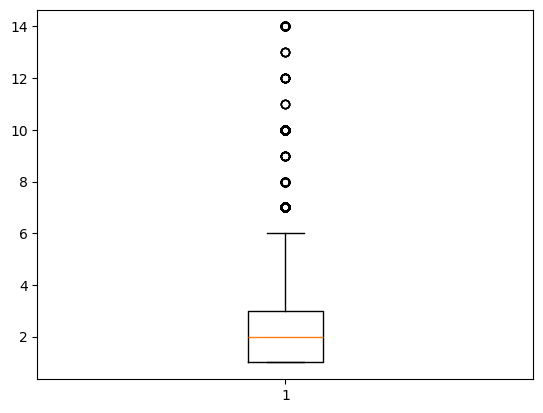

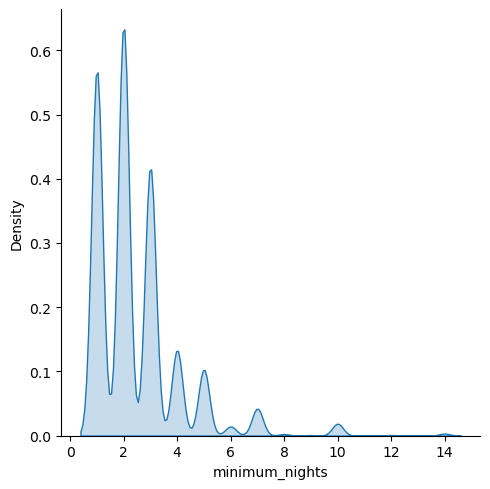

In [1819]:
plt.boxplot(df.loc[df.minimum_nights <= 14, "minimum_nights"])

sns.displot(df.loc[df.minimum_nights <= 14, :], x = "minimum_nights", kind = "kde", fill = "True")

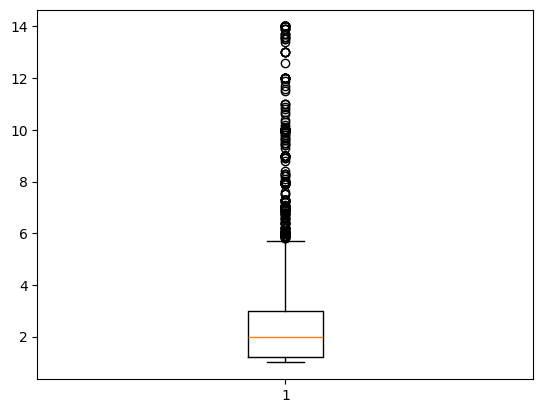

In [1820]:
### Introducing a CAP indicating 14+

CAP = 14

plt.boxplot(df.loc[df.minimum_nights_avg_ntm <= CAP, "minimum_nights_avg_ntm"])

df = df.loc[df.minimum_nights_avg_ntm <= CAP, :]
#df = [df.maximum_nights_avg_ntm <= CAP, :]

In [1821]:
# minimum_nights
# minimum_minimum_nights
# minimum_maximum_nights
# minimum_nights_avg_ntm

df[[x for x in df.columns if re.match("minimum.*", x)]]

minimum_nights  minimum_minimum_nights  minimum_maximum_nights  \
0                   5                       5                      28   
1                   2                       2                      60   
2                   1                       1                    1125   
3                   3                       3                      15   
4                   1                       5                    1125   
...               ...                     ...                     ...   
34659               2                       2                     365   
34660               2                       2                     365   
34661               2                       2                      15   
34662               2                       2                     365   
34663               2                       2                     365   

       minimum_nights_avg_ntm  
0                         5.0  
1                         2.0  
2                         1.0  
3                         3.0  
4                         5.4  
...                       ...  
34659                     2.5  
34660                     2.0  
34661                     2.1  
34662                     2.0  
34663                     2.0  

[32795 rows x 4 columns]

In [1822]:
# Values are pretty much the same (differnce = 0)
print(df.apply(lambda x: x["minimum_nights"] - x["minimum_minimum_nights"], axis = 1).value_counts())

#Values are pretty much all captured with minimum_nights and maximum_nights
drop_min_max = ["minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "maximum_nights_avg_ntm"]

df = df.drop(drop_min_max, axis = 1)

 0      29098
 1       1963
 2        705
-1        428
 3        223
 4        111
-2        104
 5         30
 6         27
-3         23
-4         17
 8          7
 9          6
 7          5
 13         5
-5          5
 25         4
 12         4
 28         3
 11         3
 23         3
 27         2
 14         2
 19         2
 26         2
-6          2
 998        1
 20         1
 59         1
 15         1
 17         1
 29         1
 199        1
 58         1
 361        1
 10         1
-12         1
Name: count, dtype: int64


In [1823]:
df.columns

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month'],
      dtype='object')

### Location Analysis

In [1825]:
df.price.count()

32795

In [1826]:
fig = px.scatter_mapbox(df, 
                  lat="latitude", 
                  lon="longitude",     
                  color="price",  
                  size_max=15, 
                  zoom=10,
                  height = 700,
                  mapbox_style = "open-street-map")


fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_layout(mapbox_style="open-street-map")

### Outliers

##### Neighborhoods

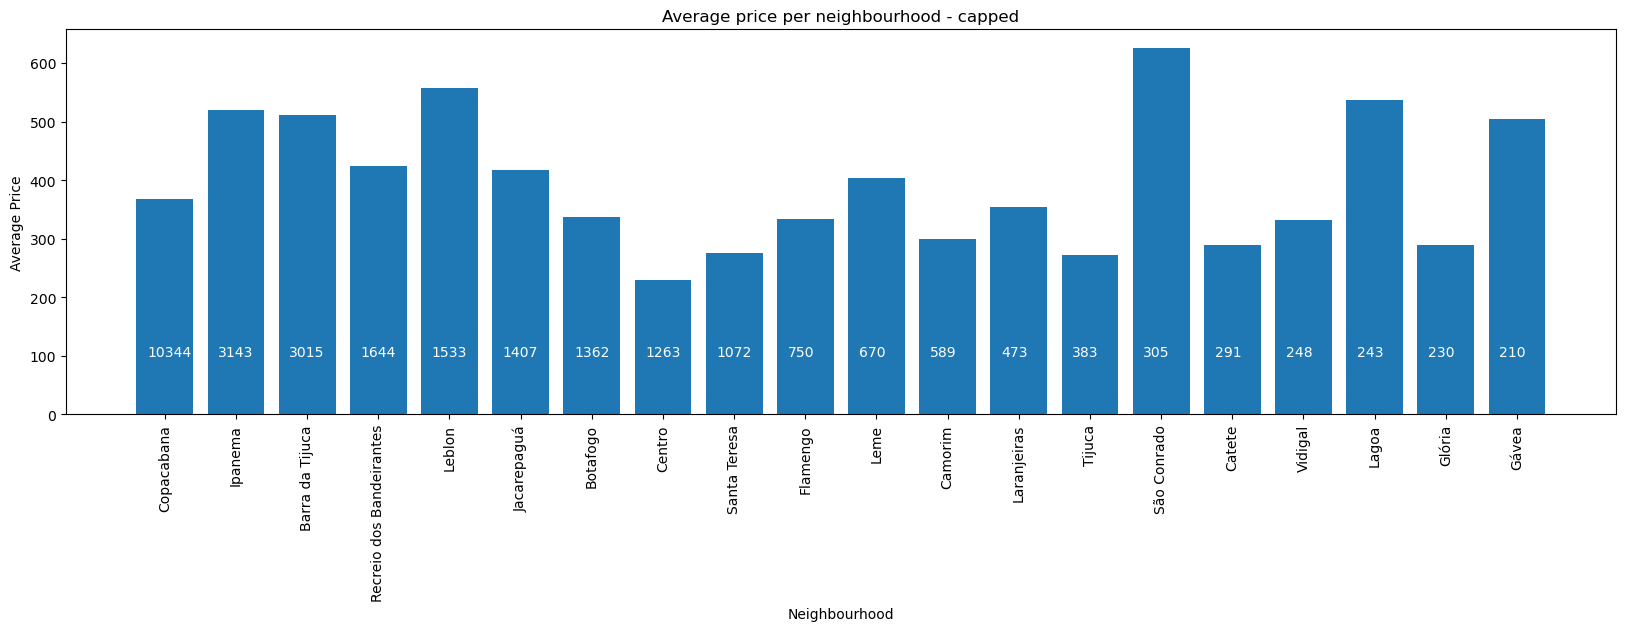

In [1829]:
NEIGHBOURHOOD_SAMPLES_CAP = 200

df_avg_neighbourhood = df[["neighbourhood_cleansed", "price"]].groupby("neighbourhood_cleansed").agg(count=('neighbourhood_cleansed','size'),
                                                                              price=('price', 'mean')).sort_values("count", ascending = False)
avg_neighbourhood = df_avg_neighbourhood.loc[df_avg_neighbourhood["count"] >= NEIGHBOURHOOD_SAMPLES_CAP].price
avg_neighbourhood_count = df_avg_neighbourhood.loc[df_avg_neighbourhood["count"] >= NEIGHBOURHOOD_SAMPLES_CAP]["count"]

sample_size = len(avg_neighbourhood.index)


plt.figure(figsize=(20, 5))
plt.bar(x = avg_neighbourhood.index, height = avg_neighbourhood)
labels = plt.xticks(rotation=90)

#Will display the count for each neighbourhood
for i in range(sample_size):
    plt.text(i-0.25,100, avg_neighbourhood_count[i], color = "white")

plt.title("Average price per neighbourhood - capped")
plt.ylabel("Average Price")
plt.xlabel("Neighbourhood")

plt.show()


# Filter to keep only representative neighbourhoods (NEIGHBOURHOOD_SAMPLES_CAP)
#list_neighbourhood_filtered = [x for x in avg_neighbourhood.index]
#df = df.loc[df.neighbourhood_cleansed.isin(list_neighbourhood_filtered), :]

In [1830]:
# Max number of neighborhoods we are considering
max_neighbourhood = 9

# Group the dataset by neighbourhood and count how many properties for each neighbourhood
df_count_neighbourhood = df.groupby("neighbourhood_cleansed").size().reset_index(name = "count").sort_values(by = "count", ascending = False)


# Select only the #max_neighbourhood neighbourhoods with the most properties
list_of_neighbourhood = df_count_neighbourhood.head(max_neighbourhood).neighbourhood_cleansed.unique()

# Filter the dataset to contain only those neighbourhoods, eliminating the outliers
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#df = df.loc[df["neighbourhood_cleansed"].isin(list_of_neighbourhood), :]
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [1831]:
df.neighbourhood_cleansed.unique()

array(['Copacabana', 'Tijuca', 'Ipanema', 'Jacarepaguá', 'Botafogo',
       'Barra da Tijuca', 'Joá', 'Flamengo', 'Santa Teresa', 'Vidigal',
       'Leblon', 'Lagoa', 'São Conrado', 'Urca',
       'Recreio dos Bandeirantes', 'Itanhangá', 'Jardim Botânico',
       'Laranjeiras', 'Gávea', 'Praça Seca', 'Humaitá', 'Leme',
       'Vila da Penha', 'Centro', 'Glória', 'Cosme Velho',
       'Vargem Pequena', 'Alto da Boa Vista', 'Rocinha', 'Estácio',
       'Maracanã', 'Penha Circular', 'Praça da Bandeira', 'Taquara',
       'Bonsucesso', 'Gamboa', 'Bangu', 'Barra de Guaratiba',
       'Rio Comprido', 'Catete', 'Engenho Novo', 'Curicica',
       'Vila Isabel', 'Piedade', 'São Francisco Xavier', 'Guaratiba',
       'Anil', 'Cavalcanti', 'Portuguesa', 'Todos os Santos', 'Grajaú',
       'Cachambi', 'Rocha Miranda', 'Riachuelo', 'Camorim', 'Cidade Nova',
       'São Cristóvão', 'Freguesia (Jacarepaguá)', 'Catumbi',
       'Campo Grande', 'Gardênia Azul', 'Pilares', 'Vargem Grande',
       'Penha

##### Bedrooms

In [1833]:
# Remove instances where value for beds and bedrooms are both 0
#df.loc[(df["bedrooms"] == 0) & (df["beds"] == 0), :].count()

df = df.loc[(df["bedrooms"] != 0) & (df["beds"] != 0), :]

##### Bathrooms

In [1835]:
df.columns
df.describe()
#Filtering bathroom > 5
#df = df.loc[df.bathrooms <= 5, :]
df.bathrooms = df.bathrooms.apply(lambda x: x if x <= 5 else 5)

#Filtering bedrooms > 5
#df = df.loc[df.bedrooms <= 5, :]
df.bedrooms = df.bedrooms.apply(lambda x: x if x <= 5 else 5)

#Filtering beds > 8
#df = df.loc[df.beds <= 8, :]
df.beds = df.beds.apply(lambda x: x if x <= 10 else 10)

df.describe()

latitude     longitude  accommodates     bathrooms      bedrooms  \
count  28808.000000  28808.000000  28808.000000  28808.000000  28808.000000   
mean     -22.968050    -43.248653      4.059220      1.551392      1.605318   
std        0.034442      0.099550      2.327456      0.860827      0.888017   
min      -23.073276    -43.723009      1.000000      0.000000      1.000000   
25%      -22.984690    -43.302442      2.000000      1.000000      1.000000   
50%      -22.973250    -43.194637      4.000000      1.000000      1.000000   
75%      -22.958967    -43.185720      5.000000      2.000000      2.000000   
max      -22.749950    -43.104400     16.000000      5.000000      5.000000   

               beds         price  minimum_nights  maximum_nights  \
count  28808.000000  28808.000000    28808.000000    28808.000000   
mean       2.465912    405.807553        2.571161      423.547522   
std        1.685628    254.128695        6.622329      422.088352   
min        1.000000     35.000000        1.000000        1.000000   
25%        1.000000    200.000000        1.000000       60.000000   
50%        2.000000    319.000000        2.000000      365.000000   
75%        3.000000    590.000000        3.000000      730.000000   
max       10.000000    850.000000     1000.000000     1125.000000   

       minimum_nights_avg_ntm  ...  number_of_reviews_ltm  \
count            28808.000000  ...           28808.000000   
mean                 2.596105  ...               8.022702   
std                  1.663477  ...              12.198257   
min                  1.000000  ...               0.000000   
25%                  1.300000  ...               0.000000   
50%                  2.000000  ...               2.000000   
75%                  3.000000  ...              11.000000   
max                 14.000000  ...             132.000000   

       number_of_reviews_l30d  review_scores_rating  review_scores_accuracy  \
count            28808.000000          22332.000000            22323.000000   
mean                 0.565468              4.801737                4.816038   
std                  1.131610              0.358599                0.356045   
min                  0.000000              0.000000                1.000000   
25%                  0.000000              4.750000                4.780000   
50%                  0.000000              4.910000                4.930000   
75%                  1.000000              5.000000                5.000000   
max                 20.000000              5.000000                5.000000   

       review_scores_cleanliness  review_scores_checkin  \
count               22324.000000           22323.000000   
mean                    4.764938               4.890716   
std                     0.397699               0.281581   
min                     1.000000               1.000000   
25%                     4.690000               4.890000   
50%                     4.890000               5.000000   
75%                     5.000000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  \
count                 22323.000000            22323.000000   
mean                      4.879300                4.864971   
std                       0.298891                0.290841   
min                       1.000000                1.000000   
25%                       4.880000                4.850000   
50%                       5.000000                4.960000   
75%                       5.000000                5.000000   
max                       5.000000                5.000000   

       review_scores_value  reviews_per_month  
count         22321.000000       22332.000000  
mean              4.717745           1.072251  
std               0.401299           1.173674  
min               1.000000           0.010000  
25%               4.640000           0.230000  
50%               4.820000          

### Correlation Heatmap

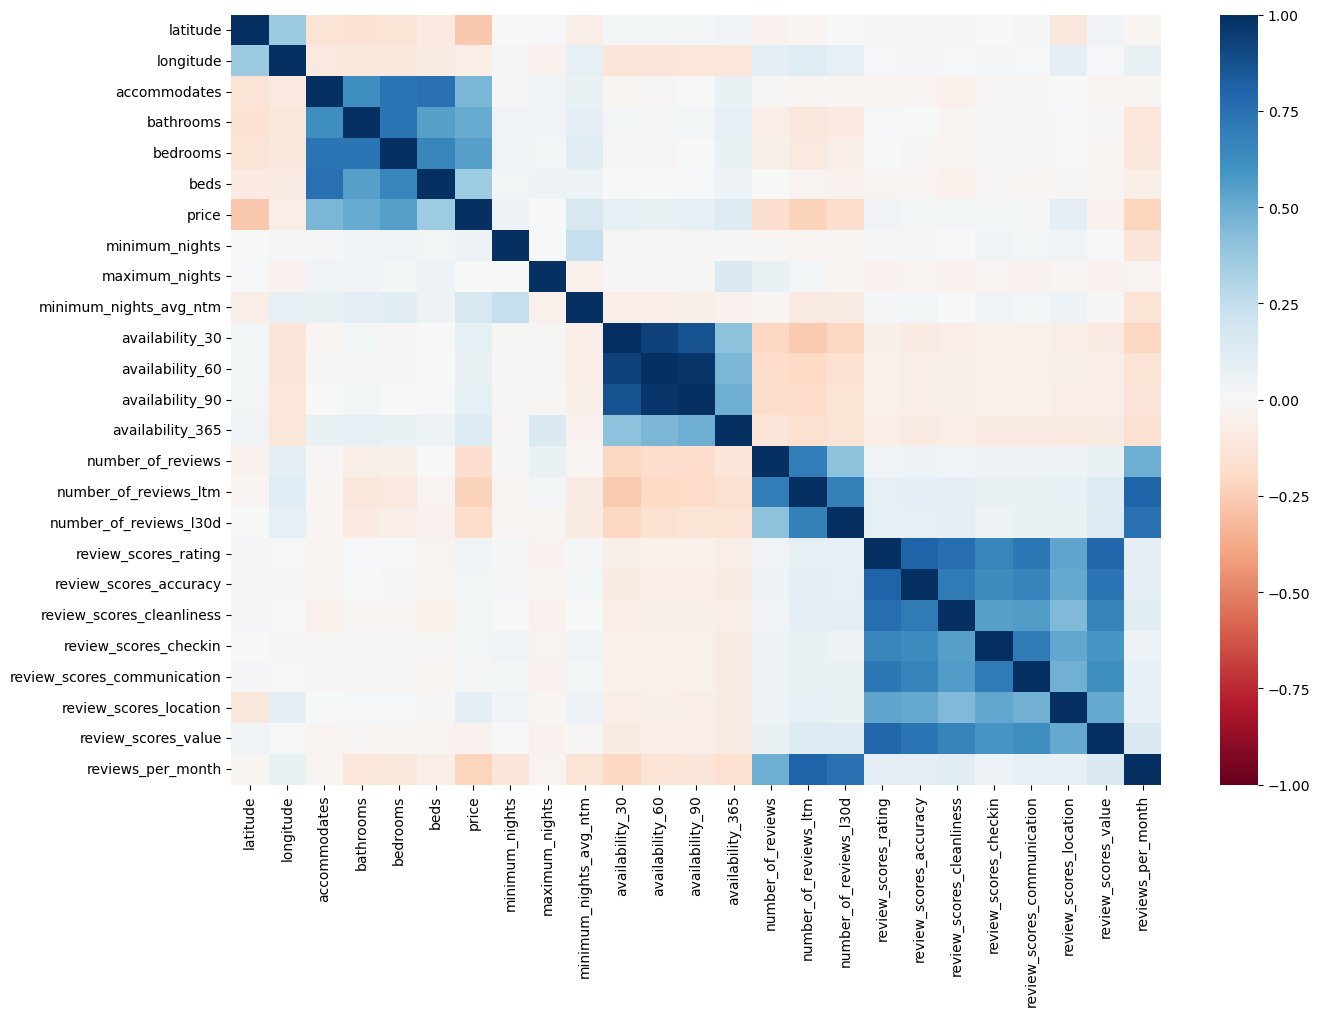

In [1837]:
plt.figure(figsize=(15,10))
correlations = df.corr(numeric_only=True)
sns.heatmap(round(correlations,2), cmap='RdBu', annot=False, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

In [1838]:
# IDEA:
# Get coordinate information to delimite a beach front area and then create another column that indicated if the property is
# at the beach or not

In [1839]:
# Number of review ltm vs price

df.corr(numeric_only = True)["price"].sort_values(ascending = False, key = abs)

price                          1.000000
bedrooms                       0.547271
bathrooms                      0.504245
accommodates                   0.462476
beds                           0.355855
latitude                      -0.272121
number_of_reviews_ltm         -0.229590
reviews_per_month             -0.215091
number_of_reviews_l30d        -0.184146
minimum_nights_avg_ntm         0.171228
number_of_reviews             -0.167560
availability_365               0.140798
review_scores_location         0.099958
availability_90                0.092311
availability_30                0.087406
availability_60                0.068059
longitude                     -0.065347
minimum_nights                 0.058296
review_scores_rating           0.043144
review_scores_value           -0.038914
review_scores_accuracy         0.032189
review_scores_checkin          0.026430
review_scores_cleanliness      0.025130
review_scores_communication    0.018470
maximum_nights                -0.001374


#### Reviews Analysis

{'whiskers': [<matplotlib.lines.Line2D at 0x2dbc6eae490>,
 'caps': [<matplotlib.lines.Line2D at 0x2dbc6eaf890>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dbadb7ba50>],
 'medians': [<matplotlib.lines.Line2D at 0x2dbc6ee8910>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dbc6ee91d0>],
 'means': []}

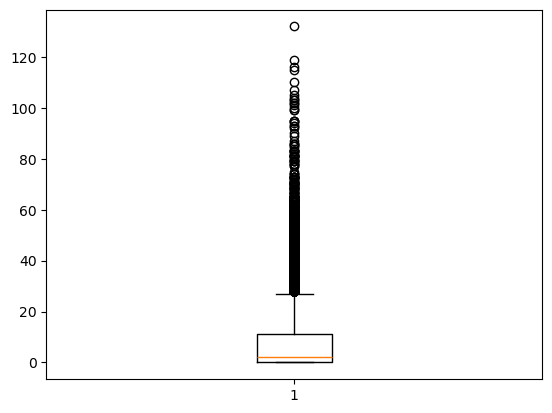

In [1841]:
plt.boxplot(df.number_of_reviews_ltm)

{'whiskers': [<matplotlib.lines.Line2D at 0x2dbc7032d90>,
 'caps': [<matplotlib.lines.Line2D at 0x2dbc7098210>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dbc7032610>],
 'medians': [<matplotlib.lines.Line2D at 0x2dbc7099350>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dbc7099c10>],
 'means': []}

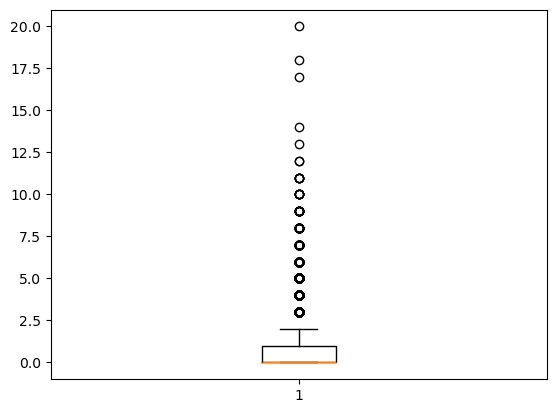

In [1842]:
plt.boxplot(df.number_of_reviews_l30d)

{'whiskers': [<matplotlib.lines.Line2D at 0x2dbc7058610>,
 'caps': [<matplotlib.lines.Line2D at 0x2dbc7059950>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dbc7013b90>],
 'medians': [<matplotlib.lines.Line2D at 0x2dbc705a8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dbc6eacd10>],
 'means': []}

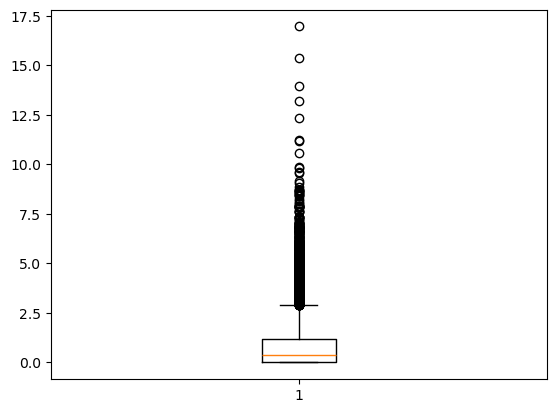

In [1843]:
df.reviews_per_month = df.reviews_per_month.fillna(0)
plt.boxplot(df.reviews_per_month)

{'whiskers': [<matplotlib.lines.Line2D at 0x2dba4a009d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2dbadaef390>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dba4a00fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x2dbadaee850>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dbadaef190>],
 'means': []}

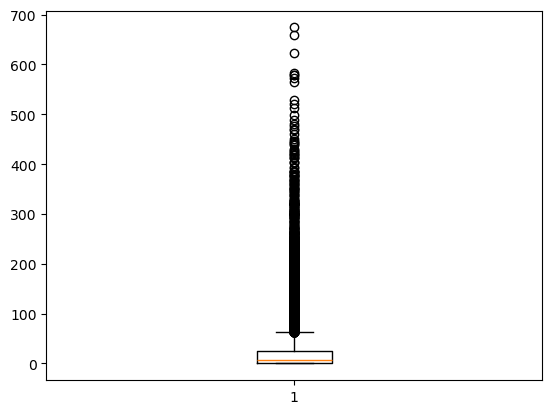

In [1844]:
plt.boxplot(df.number_of_reviews)

In [1845]:
# Capping outlier values. Will represent 100+, 4+, etc...
df.number_of_reviews = df.number_of_reviews.apply(lambda x: x if x <=100 else 100)
df.corr(numeric_only = True).price

df.number_of_reviews_l30d = df.number_of_reviews_l30d.apply(lambda x: x if x <=2.5 else 2.5)
df.corr(numeric_only = True).price

df.reviews_per_month = df.reviews_per_month.apply(lambda x: x if x <=4 else 4)
df.corr(numeric_only = True).price

df.number_of_reviews_ltm = df.number_of_reviews_ltm.apply(lambda x: x if x <=30 else 30)
df.corr(numeric_only = True).price

latitude                      -0.272121
longitude                     -0.065347
accommodates                   0.462476
bathrooms                      0.504245
bedrooms                       0.547271
beds                           0.355855
price                          1.000000
minimum_nights                 0.058296
maximum_nights                -0.001374
minimum_nights_avg_ntm         0.171228
availability_30                0.087406
availability_60                0.068059
availability_90                0.092311
availability_365               0.140798
number_of_reviews             -0.200724
number_of_reviews_ltm         -0.244652
number_of_reviews_l30d        -0.200089
review_scores_rating           0.043144
review_scores_accuracy         0.032189
review_scores_cleanliness      0.025130
review_scores_checkin          0.026430
review_scores_communication    0.018470
review_scores_location         0.099958
review_scores_value           -0.038914
reviews_per_month             -0.264820


Text(0.5, 0, 'Price')

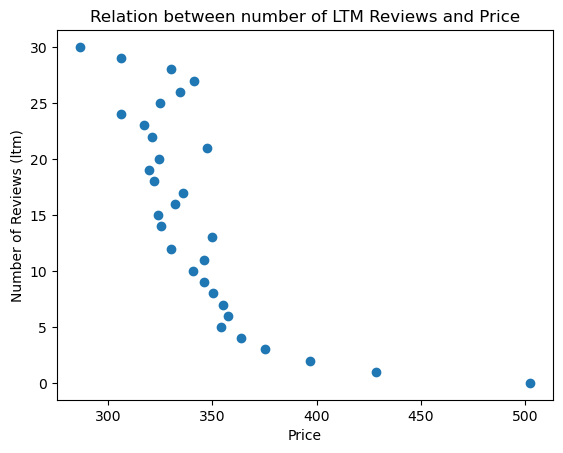

In [1846]:
# The lower the number of reviews, the higher the price
# It makes sense as lessp eople would stay in a high price property compared to a low one.

df_price_reviews = df.loc[:,["number_of_reviews_ltm", "price"]].groupby("number_of_reviews_ltm").mean().sort_values(by = "price", ascending = False)

plt.scatter(x = df_price_reviews.price, y = df_price_reviews.index)
plt.title("Relation between number of LTM Reviews and Price")
plt.ylabel("Number of Reviews (ltm)")
plt.xlabel("Price")

##### Reviews per Month

Text(0.5, 0, 'Price')

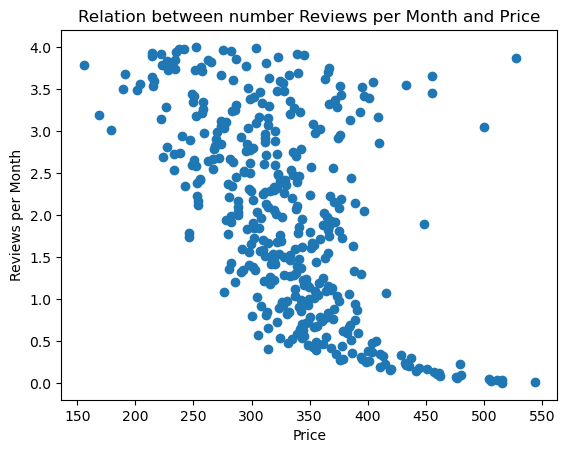

In [1848]:
df_price_reviews = df.loc[:,["reviews_per_month", "price"]].groupby("reviews_per_month").mean().sort_values(by = "price", ascending = False)

plt.scatter(x = df_price_reviews.price, y = df_price_reviews.index)
plt.title("Relation between number Reviews per Month and Price")
plt.ylabel("Reviews per Month")
plt.xlabel("Price")

##### Reviews last 30 days

Text(0.5, 0, 'Price')

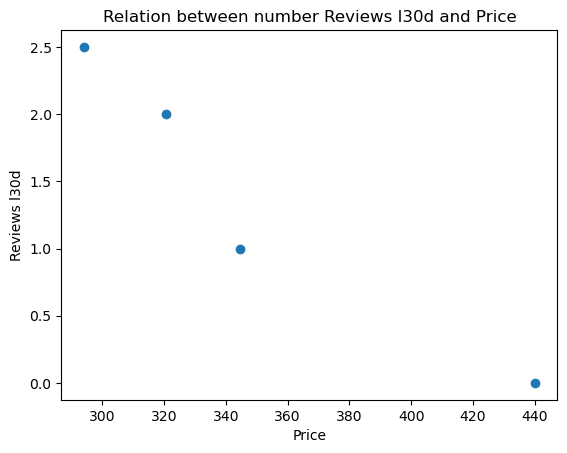

In [1850]:
df_price_reviews = df.loc[:,["number_of_reviews_l30d", "price"]].groupby("number_of_reviews_l30d").mean().sort_values(by = "price", ascending = False)

plt.scatter(x = df_price_reviews.price, y = df_price_reviews.index)
plt.title("Relation between number Reviews l30d and Price")
plt.ylabel("Reviews l30d")
plt.xlabel("Price")

##### Number of Reviews

Text(0.5, 0, 'Price')

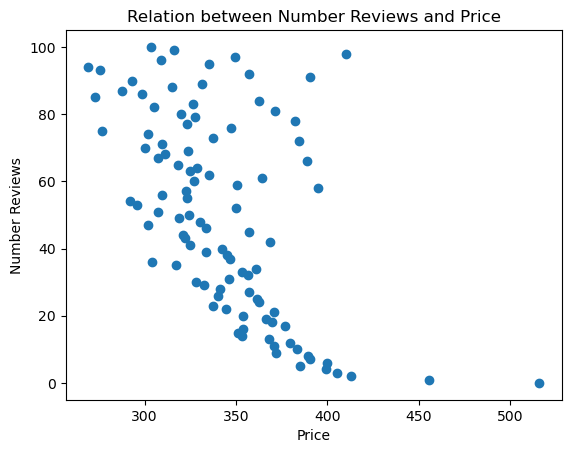

In [1852]:
df_price_reviews = df.loc[:,["number_of_reviews", "price"]].groupby("number_of_reviews").mean().sort_values(by = "price", ascending = False)

plt.scatter(x = df_price_reviews.price, y = df_price_reviews.index)
plt.title("Relation between Number Reviews and Price")
plt.ylabel("Number Reviews")
plt.xlabel("Price")

In [1853]:
# Filling missing values of Reviews per Month with 0 as the majority correspond to 0 for the LTM Reviews - which could indicate there was no review at the moment

print(df.reviews_per_month.isna().sum())

df.reviews_per_month = df.reviews_per_month.fillna(0)

0


In [1854]:
reviews_drop = ["number_of_reviews","number_of_reviews_ltm","number_of_reviews_l30d"]

df.columns
# TO REVISIT
#df = df.drop(reviews_drop, axis = 1)

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month'],
      dtype='object')

In [1855]:
cols = ["minimum_nights", "maximum_nights", "price"]
df[cols]

minimum_nights  maximum_nights  price
0                   5              28  310.0
1                   2              60  203.0
2                   1             365  220.0
3                   3              15  201.0
4                   1             730  321.0
...               ...             ...    ...
34659               2             365  673.0
34660               2             365  208.0
34661               2              15  729.0
34662               2             365  850.0
34663               2             365  480.0

[28808 rows x 3 columns]

In [1857]:
availability = ["availability_30","availability_60","availability_90","availability_365", "price"]

df[availability].corr()

availability_30  availability_60  availability_90  \
availability_30          1.000000         0.928535         0.867190   
availability_60          0.928535         1.000000         0.966939   
availability_90          0.867190         0.966939         1.000000   
availability_365         0.405788         0.455608         0.490806   
price                    0.087406         0.068059         0.092311   

                  availability_365     price  
availability_30           0.405788  0.087406  
availability_60           0.455608  0.068059  
availability_90           0.490806  0.092311  
availability_365          1.000000  0.140798  
price                     0.140798  1.000000

{'whiskers': [<matplotlib.lines.Line2D at 0x2dbc77f8ed0>,
 'caps': [<matplotlib.lines.Line2D at 0x2dbc75cb710>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dbae743d10>],
 'medians': [<matplotlib.lines.Line2D at 0x2dbc7809090>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dbc7808a90>],
 'means': []}

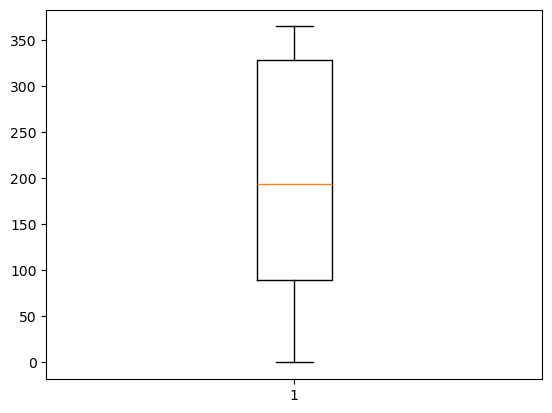

In [1858]:
plt.boxplot(df.availability_365)

{'whiskers': [<matplotlib.lines.Line2D at 0x2dbab2050d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2dbab2099d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dbab207790>],
 'medians': [<matplotlib.lines.Line2D at 0x2dbab209810>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dbab20a710>],
 'means': []}

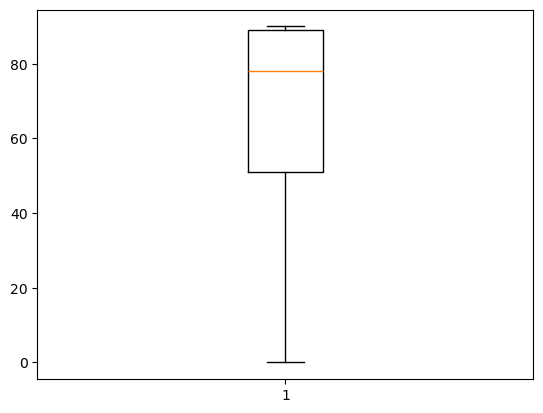

In [1859]:
plt.boxplot(df.availability_90)

{'whiskers': [<matplotlib.lines.Line2D at 0x2dbaa025d10>,
 'caps': [<matplotlib.lines.Line2D at 0x2dbaa025d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dbaa027010>],
 'medians': [<matplotlib.lines.Line2D at 0x2dbaa027d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dbaa027710>],
 'means': []}

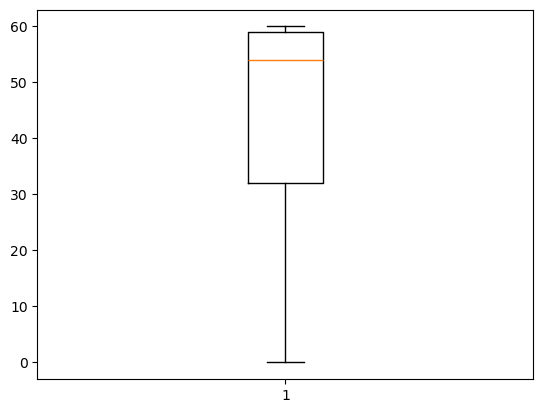

In [1860]:
plt.boxplot(df.availability_60)

{'whiskers': [<matplotlib.lines.Line2D at 0x2db919fb510>,
 'caps': [<matplotlib.lines.Line2D at 0x2db919f9f50>,
 'boxes': [<matplotlib.lines.Line2D at 0x2db99f77ed0>],
 'medians': [<matplotlib.lines.Line2D at 0x2db919f9750>],
 'fliers': [<matplotlib.lines.Line2D at 0x2db919f5a90>],
 'means': []}

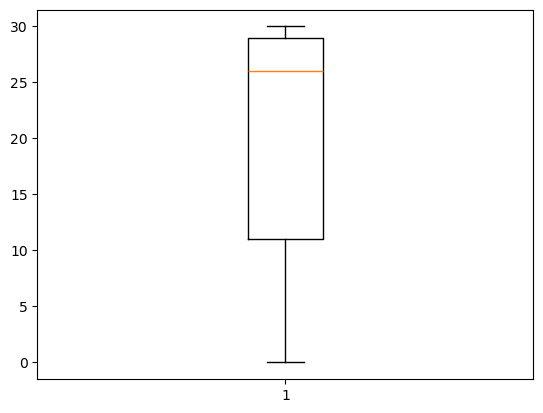

In [1861]:
plt.boxplot(df.availability_30)

In [1862]:
# Dropping features not relevant: 


# availability_365
# host_is_superhost
# minimum_nights
# has_availability

drop_feat = [
            "minimum_nights", 
             "maximum_nights", 
             #"availability_365",
             #"availability_30", 
             #"availability_60", 
             #"availability_90",
            ]

df = df.drop(drop_feat, axis = 1)

#### Score

In [1864]:
score_features = ["review_scores_value", "review_scores_accuracy", "review_scores_rating", "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication", "review_scores_location", "price"]
df.loc[:,score_features].corr()

review_scores_value  review_scores_accuracy  \
review_scores_value                     1.000000                0.734686   
review_scores_accuracy                  0.734686                1.000000   
review_scores_rating                    0.791157                0.813421   
review_scores_checkin                   0.586377                0.627485   
review_scores_cleanliness               0.673304                0.707499   
review_scores_communication             0.616341                0.673746   
review_scores_location                  0.506517                0.510843   
price                                  -0.038914                0.032189   

                             review_scores_rating  review_scores_checkin  \
review_scores_value                      0.791157               0.586377   
review_scores_accuracy                   0.813421               0.627485   
review_scores_rating                     1.000000               0.664094   
review_scores_checkin                    0.664094               1.000000   
review_scores_cleanliness                0.764993               0.549733   
review_scores_communication              0.718979               0.707721   
review_scores_location                   0.528282               0.515464   
price                                    0.043144               0.026430   

                             review_scores_cleanliness  \
review_scores_value                           0.673304   
review_scores_accuracy                        0.707499   
review_scores_rating                          0.764993   
review_scores_checkin                         0.549733   
review_scores_cleanliness                     1.000000   
review_scores_communication                   0.557945   
review_scores_location                        0.436113   
price                                         0.025130   

                             review_scores_communication  \
review_scores_value                             0.616341   
review_scores_accuracy                          0.673746   
review_scores_rating                            0.718979   
review_scores_checkin                           0.707721   
review_scores_cleanliness                       0.557945   
review_scores_communication                     1.000000   
review_scores_location                          0.478843   
price                                           0.018470   

                             review_scores_location     price  
review_scores_value                        0.506517 -0.038914  
review_scores_accuracy                     0.510843  0.032189  
review_scores_rating                       0.528282  0.043144  
review_scores_checkin                      0.515464  0.026430  
review_scores_cleanliness                  0.436113  0.025130  
review_scores_communication                0.478843  0.018470  
review_scores_location                     1.000000  0.099958  
price                                      0.099958  1.000000

In [1865]:
df[score_features].isna().sum()

review_scores_value            6487
review_scores_accuracy         6485
review_scores_rating           6476
review_scores_checkin          6485
review_scores_cleanliness      6484
review_scores_communication    6485
review_scores_location         6485
price                             0
dtype: int64

In [1866]:
df.corr(numeric_only = True).price

def replace_na_score(criteria):
    df["is_score_"+ criteria + "_empty"] = df["review_scores_"+ criteria].isna()*1
    df["review_scores_"+ criteria] = df["review_scores_"+ criteria].fillna(3)

replace_na_score("location")
#replace_na_score("rating")


df[["is_score_location_empty", "review_scores_location"]]
#df[["is_score_rating_empty", "review_scores_rating"]]

is_score_location_empty  review_scores_location
0                            0                    4.77
1                            0                    4.84
2                            0                    4.80
3                            0                    4.94
4                            0                    4.97
...                        ...                     ...
34659                        1                    3.00
34660                        1                    3.00
34661                        1                    3.00
34662                        1                    3.00
34663                        1                    3.00

[28808 rows x 2 columns]

In [1867]:
# Dropping reviews score. Low correlation

# review_scores_value
# review_scores_rating
# review_scores_accuracy
# review_scores_checkin
# review_scores_cleanliness
# review_scores_communication
# review_scores_location 

#  "review_scores_rating"

drop_reviews = [
                "review_scores_value", 
                "review_scores_accuracy", 
                "review_scores_rating",
                "review_scores_checkin", 
                "review_scores_cleanliness",
                "review_scores_communication",
                #"review_scores_location",
]

df = df.drop(drop_reviews, axis = 1)

In [1868]:
df.corr(numeric_only = True).price

latitude                  -0.272121
longitude                 -0.065347
accommodates               0.462476
bathrooms                  0.504245
bedrooms                   0.547271
beds                       0.355855
price                      1.000000
minimum_nights_avg_ntm     0.171228
availability_30            0.087406
availability_60            0.068059
availability_90            0.092311
availability_365           0.140798
number_of_reviews         -0.200724
number_of_reviews_ltm     -0.244652
number_of_reviews_l30d    -0.200089
review_scores_location    -0.195650
reviews_per_month         -0.264820
is_score_location_empty    0.232802
Name: price, dtype: float64

In [1869]:
print(df.isna().sum())

#df = df.dropna()

host_response_time         4747
host_response_rate         4747
host_acceptance_rate       2782
host_is_superhost           730
host_verifications            0
host_has_profile_pic          0
host_identity_verified        0
neighbourhood_cleansed        0
latitude                      0
longitude                     0
property_type                 0
room_type                     0
accommodates                  0
bathrooms                     0
bathrooms_text               33
bedrooms                      0
beds                          0
amenities                     0
price                         0
minimum_nights_avg_ntm        0
has_availability            229
availability_30               0
availability_60               0
availability_90               0
availability_365              0
number_of_reviews             0
number_of_reviews_ltm         0
number_of_reviews_l30d        0
review_scores_location        0
instant_bookable              0
reviews_per_month             0
is_score

### Categorical Data

In [1871]:
# instant_bookable - low correlation
# has_availability - same value for all/majority
low_corr = ["has_availability", "instant_bookable"]

df = df.drop(low_corr, axis = 1)

Text(0.5, 1.0, 'Acceptance rate X Price')

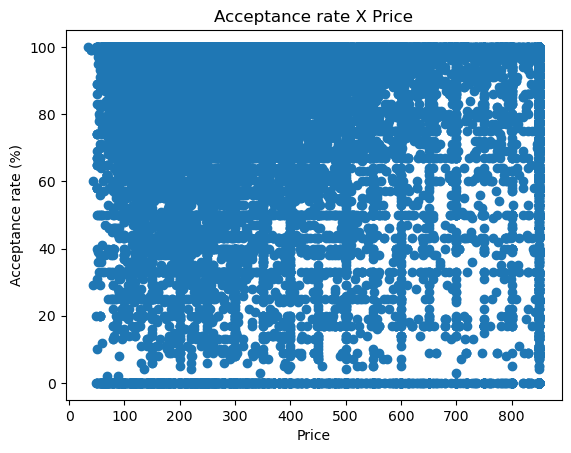

In [1872]:
#We can see from the chart below that the response rate does not influence the price, as we have low and high prices with 100% repsonse rate for example

df.host_acceptance_rate = df.host_acceptance_rate.apply(lambda x : float(x.split("%")[0]) if isinstance(x, str) else x)
plt.scatter(x = df.price, y = df.host_acceptance_rate)
plt.ylabel("Acceptance rate (%)")
plt.xlabel("Price")
plt.title("Acceptance rate X Price")

Text(0.5, 1.0, 'Response rate X Price')

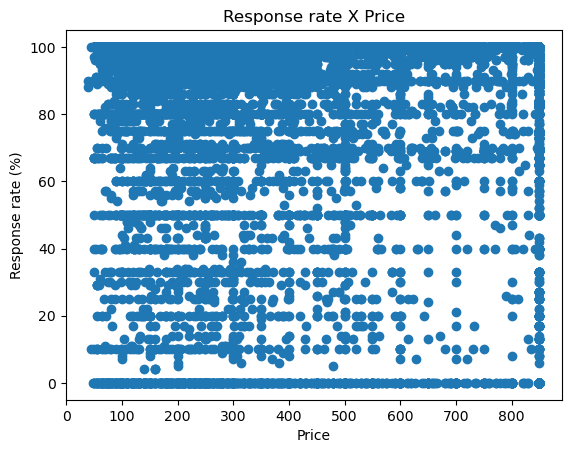

In [1873]:
# Same results for response rate

df.host_response_rate = df.host_response_rate.apply(lambda x : float(x.split("%")[0]) if isinstance(x, str) else x)
plt.scatter(x = df.price, y = df.host_response_rate)
plt.ylabel("Response rate (%)")
plt.xlabel("Price")
plt.title("Response rate X Price")

In [1874]:
# Host Super Host
# No apparent real correlation: superhost has an average lower price.
# Also, superhost are a minority.

print(df.groupby("host_is_superhost").mean(numeric_only = True).price)
print(df.host_is_superhost.value_counts())

host_is_superhost
f    427.036376
t    361.491650
Name: price, dtype: float64
host_is_superhost
f    19216
t     8862
Name: count, dtype: int64


In [1875]:
# Drop Response/Acceptance rate
df = df.drop(["host_response_rate", "host_acceptance_rate", "host_is_superhost"], axis = 1)

In [1876]:
# Removing low correlations 
low_corr = ["host_has_profile_pic", "host_identity_verified"]
df = df.drop(low_corr, axis = 1)

### Dealing with Nans

In [1878]:
df.isna().sum()

host_response_time         4747
host_verifications            0
neighbourhood_cleansed        0
latitude                      0
longitude                     0
property_type                 0
room_type                     0
accommodates                  0
bathrooms                     0
bathrooms_text               33
bedrooms                      0
beds                          0
amenities                     0
price                         0
minimum_nights_avg_ntm        0
availability_30               0
availability_60               0
availability_90               0
availability_365              0
number_of_reviews             0
number_of_reviews_ltm         0
number_of_reviews_l30d        0
review_scores_location        0
reviews_per_month             0
is_score_location_empty       0
dtype: int64

In [1879]:
# host_response_time

df.isna().sum()

le = LabelEncoder()

copy_df = pd.DataFrame()
copy_df["host_response_time"] = le.fit_transform(df.host_response_time)
copy_df["price"] = df.price

#host_response_time does not correlate to the price
# We solve the Nan problem as well
print(copy_df.corr())

df = df.drop("host_response_time", axis = 1)

                    host_response_time     price
host_response_time            1.000000  0.005011
price                         0.005011  1.000000


In [1880]:
# bathrooms - contains the same information about the number of bathrooms as bathrooms_text
# bathrooms_text - keeping this feature for later extraction of private/shared bathroom information. It will be dropped later

df = df.dropna(subset = "bathrooms")

In [1881]:
# bedrooms - cannot impute the value based on the dataset. So dropping all these nas
# beds - same reason for beds

df = df.dropna(subset = ["bedrooms", "beds"])

### Property Type

In [1883]:
# property_type: info  already capture with is_entire_property
# host_verifications: majority of values are the same

df = df.drop(["property_type", "host_verifications"], axis = 1)
#df = df.drop(["host_verifications"], axis = 1)

In [1884]:
df.isna().sum()

neighbourhood_cleansed      0
latitude                    0
longitude                   0
room_type                   0
accommodates                0
bathrooms                   0
bathrooms_text             33
bedrooms                    0
beds                        0
amenities                   0
price                       0
minimum_nights_avg_ntm      0
availability_30             0
availability_60             0
availability_90             0
availability_365            0
number_of_reviews           0
number_of_reviews_ltm       0
number_of_reviews_l30d      0
review_scores_location      0
reviews_per_month           0
is_score_location_empty     0
dtype: int64

### Encoding room_type

In [1886]:
df.groupby("room_type").mean(numeric_only = True)[["price"]]

price
room_type                  
Entire home/apt  445.439726
Hotel room       426.090909
Private room     271.631827
Shared room      177.038817

In [1887]:
print(df.room_type.value_counts())

room_type
Entire home/apt    22514
Private room        5731
Shared room          541
Hotel room            22
Name: count, dtype: int64


In [1888]:
print(df.room_type.value_counts())

#Remove Hotel Rooms and Shared Roms (outliers)
#df = df.loc[(df.room_type != "Hotel room"),:]
df = df.loc[(df.room_type != "Hotel room") &
            (df.room_type != "Shared room"), :]

#df.room_type = df.room_type.apply(lambda x : "Private Room" if x == "Shared Room" else x )

# Label Encode room_type category (binary value 0/1)
le = LabelEncoder()
df["is_entire_home"] = le.fit_transform(df["room_type"])
df["is_entire_home"] = df["is_entire_home"].apply(lambda x : 1 - x)

df = df.drop("room_type", axis = 1)

room_type
Entire home/apt    22514
Private room        5731
Shared room          541
Hotel room            22
Name: count, dtype: int64


### Extracting private/share bathroom information

In [1890]:
df.bathrooms_text.unique()

# Create columns with shared bath boolean and another with number of bathrooms

    
def bathroom_number(a_bath):

    number_bath = 0 #default value
    is_shared = 0 #default value
    
    # Handling missing values
    if(pd.isna(a_bath)):

        number_bath = np.nan
        is_shared = np.nan
    else:

        #Split the bathroom string
        bath_split = a_bath.split()    

        try:
            #Case has-a-number
            number_bath = float(bath_split[0])   #If element not a number it will execute the exception code

           
            #Case has-a-number + shared
            if(re.match(".*shared.*", str.lower(a_bath))):
                is_shared = 1

        except:
            #Case dont-have-number
            if(re.match(".*half-bath.*", str.lower(a_bath))):
                number_bath = 0.5
            #Case dont-have-number + shared
            if(re.match(".*shared.*", str.lower(a_bath))):
                is_shared = 1  
          
 
    return number_bath, is_shared
            
    

df[["number_bathroom", "is_bathroom_shared"]] = df["bathrooms_text"].apply(lambda x: pd.Series(bathroom_number(x)))

# Dropping original feature wwith number and shared info
df = df.drop(["bathrooms_text", "number_bathroom"], axis = 1)

## !! number_bathroom is reduntant since this info is already in the "bathroom" feature

In [1891]:
# Recover this information from is_entire_home.
# If the apartment is private (all for the renter) then the toilet is ASSUMED to be private too
df.loc[df["is_bathroom_shared"].isna(), "is_bathroom_shared"] = df.loc[df["is_bathroom_shared"].isna(), "is_entire_home"].apply(lambda x: abs(x-1))

In [1892]:
df.isna().sum()

neighbourhood_cleansed     0
latitude                   0
longitude                  0
accommodates               0
bathrooms                  0
bedrooms                   0
beds                       0
amenities                  0
price                      0
minimum_nights_avg_ntm     0
availability_30            0
availability_60            0
availability_90            0
availability_365           0
number_of_reviews          0
number_of_reviews_ltm      0
number_of_reviews_l30d     0
review_scores_location     0
reviews_per_month          0
is_score_location_empty    0
is_entire_home             0
is_bathroom_shared         0
dtype: int64

#Option 1: With seabron
sns.pairplot( data = df)
#Option 2
#mtrx = pd.plotting.scatter_matrix(df)

#### Expensive property analysis

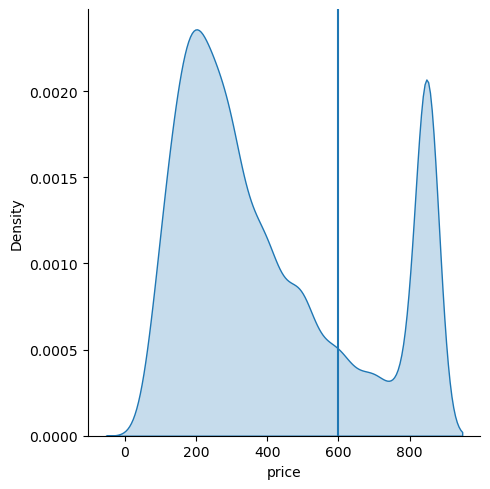

In [1895]:
sns.displot(df, x = "price", kind = "kde", fill = "True")
plt.axvline(600)

In [1896]:
df_rich = df.loc[df.price > 600, :]

### Extracting amenities information

In [1898]:
features = set()

features_dict = {}

features_dict_poor = {}

# Convert the amenities string into a list of amenities
def add_amenities_to_set(amenities):
    amenities_proc = amenities.replace("[", "").replace("]", "").replace('"', "")
    amenitites_splitted = amenities_proc.split(", ")
    features.update(amenitites_splitted)
    
    for amn in amenitites_splitted:
        if amn in features_dict:
            features_dict.update({amn : features_dict[amn] + 1})
        else:
            features_dict.update({amn : 1})
            
def add_amenities_to_set2(amenities):
    amenities_proc = amenities.replace("[", "").replace("]", "").replace('"', "")
    amenitites_splitted = amenities_proc.split(", ")
    features.update(amenitites_splitted)
    
    for amn in amenitites_splitted:
        if amn in features_dict_poor:
            features_dict_poor.update({amn : features_dict_poor[amn] + 1})
        else:
            features_dict_poor.update({amn : 1})

#Check what kind of features the properties with price higher than 80% of the PRICE_CAP
#df_rich = df.loc[df.price >= PRICE_CAP*0.8, :]    
df_rich = df.loc[df.price >= 600, :]    
df_poor = df.loc[df.price < 600, :]    
    
df_rich.amenities.apply(lambda x: add_amenities_to_set(x))
df_poor.amenities.apply(lambda x: add_amenities_to_set2(x))

print(len(features))
features

df_amn_count_rich = pd.DataFrame.from_dict(features_dict, orient='index', columns = ["rich count"])
df_amn_count_rich = df_amn_count_rich.sort_values(by = "rich count", ascending = False)

df_amn_count_poor = pd.DataFrame.from_dict(features_dict_poor, orient='index', columns = ["poor count"])
df_amn_count_poor= df_amn_count_poor.sort_values(by = "poor count", ascending = False)

#features_dict

4552


In [1899]:
print(df_amn_count_rich.shape)
print(df_amn_count_poor.shape)

(1813, 1)
(3908, 1)


In [1900]:
print(df.loc[df.price >= 600, :].shape)    
print(df.loc[df.price < 600, :].shape)   

(7058, 22)
(21187, 22)


In [1901]:
# This Data Frame shows the % of the presence of the amenities for the expensive properties and the cheap properties.
# The diff column shows the difference between these percentages. The goal was to identify the cases where the presence of the amenitiy was higher for
# the expensive properties.

process = df_amn_count_rich.merge(df_amn_count_poor, how="outer", left_index = True, right_index = True).sort_values(by="rich count", ascending = False)


process["rich count"] = (process["rich count"]*100)/(df.loc[df.price >= 600, :].shape[0]) 
process["poor count"] = (process["poor count"]*100)/(df.loc[df.price < 600, :].shape[0]) 
process["diff"] = process["rich count"] - process["poor count"]

process.sort_values(by = "diff", ascending = True).head(30)

rich count  poor count       diff
Bed linens                        50.070842   65.441072 -15.370231
Dishes and silverware             57.820912   71.661868 -13.840956
Hot water                         57.126665   70.392222 -13.265557
Lock on bedroom door               3.584585   15.844622 -12.260037
Laundromat nearby                 19.467271   31.047340 -11.580069
Long term stays allowed           28.790026   39.925426 -11.135400
Room-darkening shades             33.578918   44.522585 -10.943667
Ceiling fan                       14.465854   25.350451 -10.884596
Self check-in                     23.448569   33.964223 -10.515654
Clothing storage: wardrobe        15.797676   25.827158 -10.029482
Cooking basics                    52.026070   61.462217  -9.436148
Cleaning products                 24.737886   33.459197  -8.721311
Microwave                         47.775574   56.435550  -8.659976
Extra pillows and blankets        31.099462   39.344881  -8.245420
Refrigerator                      48.455653   56.572426  -8.116773
Drying rack for clothing          31.099462   39.075848  -7.976387
Body soap                         16.392746   23.981687  -7.588941
Portable fans                     11.348824   18.634068  -7.285244
Hangers                           57.962596   64.629254  -6.666658
Free street parking               15.896855   21.862463  -5.965608
Window AC unit                     8.798526   14.556096  -5.757569
Coffee maker: drip coffee maker   10.144517   15.769104  -5.624587
Host greets you                   17.710400   23.066031  -5.355632
Essentials                        64.168320   69.509605  -5.341285
Luggage dropoff allowed           20.034004   25.322131  -5.288128
Shared beach access               10.314537   15.098881  -4.784345
Mini fridge                        5.695664   10.218530  -4.522866
Clothing storage                   8.160952   12.380233  -4.219281
Paid parking lot off premises      2.748654    6.947657  -4.199003
Blender                           28.492491   32.548261  -4.055770

In [1902]:


######################################################
#List of amenities being considered (TO BE REVISED !)#
######################################################
amenities_list_re = { "parking": ".*parking on premises.*", 
                     "pool":".*pool.*(?!.*\btable\b).*", 
                     "pool_table": ".*pool table.*",
                     "ac1": ".*air conditioning.*",
                     "ac2":".* ac .*",
                     "washer": ".*washer.*",
                     "bathtub1": ".*bathtub.*",
                     "bathtub2": ".*hot tub.*",
                     "beach_view1": ".*beach view.*",
                     "beach_view2": ".*sea view.*",
                     "beach_view3": ".*ocean view.*",
                     "beach_access1": ".*waterfront*",
                     "beach_access2": ".*beach access*",
                     "sauna": ".*sauna.*",
                     "gym" : ".*gym.*",
                     "piano": ".*piano.*",
                     "dishwasher": ".*dishwasher.*",
                     "dryer": ".*dryer.*",
                     "ceiling_fan" : ".*ceiling fan.*",
                     "long_term" : ".*long term.*",
                     "bbq_grill" : ".*bbq grill.*",
                     "self_checkin" : ".*self check-in.*",
                      }
        
    
#Create the has_amenities columns
has_amn_feat = ["has_" + x for x in amenities_list_re.keys()]

#Default value 0 (does not have amenity)
df[has_amn_feat] = 0


def convert_amenities(amenities, index): 
    for amn_name, amn_re in amenities_list_re.items():
        if(re.match(amn_re, str.lower(amenities))):
  
            df.loc[index,"has_"+ amn_name] = 1

for index, row in df.iterrows():
    convert_amenities(df.loc[index, "amenities"], index)

# Merge features
df["has_ac"] = df.apply(lambda x: (x["has_ac1"] or x["has_ac2"]), axis = 1)
df["has_bathtub"] = df.apply(lambda x: (x["has_bathtub1"] or x["has_bathtub2"]), axis = 1)
df["has_seaview"] = df.apply(lambda x: (x["has_beach_view1"] or x["has_beach_view2"] or x["has_beach_view3"]), axis = 1)
df["has_beach_access"] = df.apply(lambda x: (x["has_beach_access1"] or x["has_beach_access2"]), axis = 1)

# Drop aac1 and ac2 and amenities features
df = df.drop(["has_ac1", "has_ac2","has_bathtub1","has_bathtub2","has_beach_view1","has_beach_view2", "has_beach_view3",
              "amenities", "has_beach_access1", "has_beach_access2"], axis = 1)

#df = df.drop(["has_ac1", "has_ac2","has_bathtub1","has_bathtub2","has_beach_view1","has_beach_view2", "has_beach_view3"], axis = 1)

In [1903]:
df_categorical = df.select_dtypes(include = 'object')
df_categorical

neighbourhood_cleansed
0                 Copacabana
1                 Copacabana
2                     Tijuca
3                 Copacabana
4                    Ipanema
...                      ...
34659             Copacabana
34660               Botafogo
34661                 Leblon
34662             Copacabana
34663                  Lagoa

[28245 rows x 1 columns]

In [1904]:
# Confirming the absence of missing values
df.isna().sum()

neighbourhood_cleansed     0
latitude                   0
longitude                  0
accommodates               0
bathrooms                  0
bedrooms                   0
beds                       0
price                      0
minimum_nights_avg_ntm     0
availability_30            0
availability_60            0
availability_90            0
availability_365           0
number_of_reviews          0
number_of_reviews_ltm      0
number_of_reviews_l30d     0
review_scores_location     0
reviews_per_month          0
is_score_location_empty    0
is_entire_home             0
is_bathroom_shared         0
has_parking                0
has_pool                   0
has_pool_table             0
has_washer                 0
has_sauna                  0
has_gym                    0
has_piano                  0
has_dishwasher             0
has_dryer                  0
has_ceiling_fan            0
has_long_term              0
has_bbq_grill              0
has_self_checkin           0
has_ac        

In [1905]:
df.columns

Index(['neighbourhood_cleansed', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_location', 'reviews_per_month',
       'is_score_location_empty', 'is_entire_home', 'is_bathroom_shared',
       'has_parking', 'has_pool', 'has_pool_table', 'has_washer', 'has_sauna',
       'has_gym', 'has_piano', 'has_dishwasher', 'has_dryer',
       'has_ceiling_fan', 'has_long_term', 'has_bbq_grill', 'has_self_checkin',
       'has_ac', 'has_bathtub', 'has_seaview', 'has_beach_access'],
      dtype='object')

In [1906]:
df.is_entire_home.value_counts()

is_entire_home
1    22514
0     5731
Name: count, dtype: int64

<Axes: xlabel='accommodates', ylabel='price'>

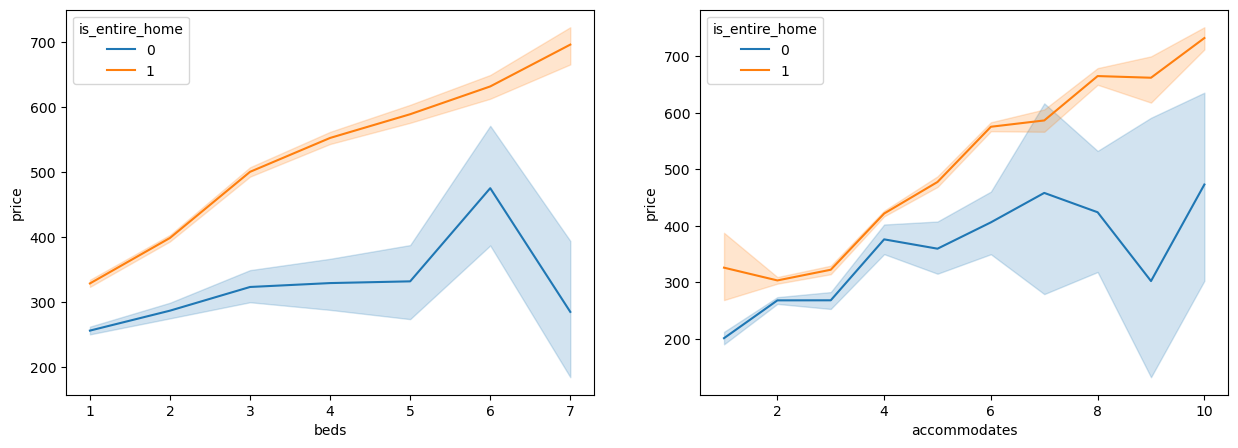

In [1907]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# Min 1 bed and max 7 beds
sns.lineplot(ax =ax[0] , data = df.loc[(df.beds <=7) & (df.beds > 0),:], x="beds", y="price", hue = "is_entire_home")

# Min 1 ppl and max 10 ppl
sns.lineplot(ax = ax[1], data = df.loc[(df.accommodates <=10) & (df.accommodates > 0),:], x="accommodates", y="price", hue = "is_entire_home")

## Clustering with geolocation

In [1909]:
df.columns

Index(['neighbourhood_cleansed', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_location', 'reviews_per_month',
       'is_score_location_empty', 'is_entire_home', 'is_bathroom_shared',
       'has_parking', 'has_pool', 'has_pool_table', 'has_washer', 'has_sauna',
       'has_gym', 'has_piano', 'has_dishwasher', 'has_dryer',
       'has_ceiling_fan', 'has_long_term', 'has_bbq_grill', 'has_self_checkin',
       'has_ac', 'has_bathtub', 'has_seaview', 'has_beach_access'],
      dtype='object')

In [1910]:
from sklearn.cluster import KMeans

In [1911]:
# Initialize the model
k_means = KMeans(
    init = "random",
    n_clusters = 25,
    n_init = 10,
    max_iter = 500,
    random_state = 69
)


#Prepare the data
#df_kmeans = df.loc[:,["latitude", "longitude", "has_beach_access"]]
df_kmeans = df.loc[:,["latitude", "longitude"]]

# Fitting
k_means.fit(df_kmeans)

#Clusters as a feature
df_kmeans['cluster'] = k_means.labels_ 
df_kmeans['price'] = df.price


In [1912]:
fig = px.scatter_mapbox(df_kmeans, 
                  lat="latitude", 
                  lon="longitude",     
                  color="cluster",
                  hover_name = "price", 
                  size_max=15, 
                  zoom=10,
                  height = 700,
                  mapbox_style = "open-street-map")


fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_layout(mapbox_style="open-street-map")

In [1913]:
# Create afeature with the average price for different zones (not necessarily the same division as the neighbourhood)
df['cluster_zone_beach_access'] = df_kmeans['cluster']

In [1914]:
# Dropping latitude and longitude
# Info alaready capture with the division into different neighbourhoods
df = df.drop(["longitude", "latitude"], axis = 1)

In [1915]:
df.corr(numeric_only = True).price.sort_values(ascending = False)

price                        1.000000
bedrooms                     0.555373
bathrooms                    0.524073
accommodates                 0.484600
beds                         0.397173
is_entire_home               0.276167
is_score_location_empty      0.241353
has_pool                     0.239927
has_parking                  0.238613
has_bathtub                  0.196469
has_washer                   0.193052
minimum_nights_avg_ntm       0.162712
has_dishwasher               0.157794
availability_365             0.148512
has_ac                       0.140198
has_seaview                  0.125636
has_bbq_grill                0.117055
availability_90              0.104123
availability_30              0.101284
has_gym                      0.081075
availability_60              0.080055
has_sauna                    0.056099
has_pool_table               0.051951
has_dryer                    0.046609
has_beach_access             0.021754
has_piano                    0.008515
has_self_che

In [1916]:
# Low amenities correlation
#last_drop = ["has_pool", "has_ac","cluster_zone_beach_access" , "has_sauna", "has_piano", "has_beach_access", "has_pool_table", "has_dryer", "has_long_term"]
last_drop = ["has_sauna", "has_piano", "has_beach_access", "has_pool_table", "has_dryer", "has_gym"]

df = df.drop(last_drop, axis = 1)

In [1917]:
df.head()

neighbourhood_cleansed  accommodates  bathrooms  bedrooms  beds  price  \
0             Copacabana             5        1.0       2.0   2.0  310.0   
1             Copacabana             3        1.0       1.0   2.0  203.0   
2                 Tijuca             2        1.0       1.0   1.0  220.0   
3             Copacabana             2        1.5       1.0   1.0  201.0   
4                Ipanema             2        1.0       1.0   1.0  321.0   

   minimum_nights_avg_ntm  availability_30  availability_60  availability_90  \
0                     5.0                6               32               51   
1                     2.0               24               54               71   
2                     1.0                9               29               41   
3                     3.0                5               10               24   
4                     5.4               13               43               73   

   ...  has_washer  has_dishwasher  has_ceiling_fan  has_long_term  \
0  ...           0               0                0              0   
1  ...           0               0                1              0   
2  ...           1               1                1              1   
3  ...           0               0                0              0   
4  ...           1               0                1              1   

   has_bbq_grill  has_self_checkin  has_ac  has_bathtub  has_seaview  \
0              0                 1       1            1            0   
1              0                 1       1            0            0   
2              0                 0       1            0            0   
3              0                 1       1            0            1   
4              0                 1       1            0            0   

   cluster_zone_beach_access  
0                         22  
1                          0  
2                         17  
3                          3  
4                         13  

[5 rows x 31 columns]

In [1918]:
#df = df.drop("cluster_zone_beach_access", axis = 1)
df = df.drop("neighbourhood_cleansed", axis = 1)

### Binary Encoding option

In [1920]:
import category_encoders as ce
#bin_encoder = ce.BinaryEncoder(cols = ['neighbourhood_cleansed'] , return_df = True)
bin_encoder = ce.BinaryEncoder(cols = ['cluster_zone_beach_access'] , return_df = True)
#bin_encoder = ce.BinaryEncoder(cols = ['neighbourhood_cleansed', 'cluster_zone_beach_access'] , return_df = True)
#bin_encoder = ce.BinaryEncoder(cols = ['neighbourhood_cleansed', 'cluster_zone_beach_access', 'property_type'] , return_df = True)

df_bin = bin_encoder.fit_transform(df.drop("price", axis = 1))

### Label Encoding

In [1922]:
from sklearn import preprocessing 

label_encoder = preprocessing.LabelEncoder() 

df_label = df.drop("price", axis = 1).copy(deep = True)
#df_label["neighbourhood_cleansed"] = label_encoder.fit_transform(df_label["neighbourhood_cleansed"])
df_label["cluster_zone_beach_access"] = label_encoder.fit_transform(df_label["cluster_zone_beach_access"])
#df_label["property_type"] = label_encoder.fit_transform(df_label["property_type"])

### One-Hod-Encoding option

In [1924]:
## Another option could be with get_dummies
from sklearn.preprocessing import OneHotEncoder

onehot_encoder_neighbourhood = OneHotEncoder(sparse_output = False)
onehot_encoder_cluster = OneHotEncoder(sparse_output = False, feature_name_combiner='concat')
#onehot_encoder_property = OneHotEncoder(sparse_output = False)

#series_onehot = onehot_encoder_neighbourhood.fit_transform(df[["neighbourhood_cleansed"]])

series_cluster_onehot = onehot_encoder_cluster.fit_transform(df[["cluster_zone_beach_access"]])

#series_property_onehot = onehot_encoder_property.fit_transform(df[["property_type"]])

In [1925]:
df_onehot = df.drop("price", axis = 1).copy(deep = True)

#df_onehot[onehot_encoder_neighbourhood.categories_[0]] = series_onehot
#df_onehot = df_onehot.drop("neighbourhood_cleansed", axis = 1)

df_onehot[onehot_encoder_cluster.categories_[0]] = series_cluster_onehot
df_onehot = df_onehot.drop("cluster_zone_beach_access", axis = 1)

#df_onehot[onehot_encoder_property.categories_[0]] = series_property_onehot
#df_onehot = df_onehot.drop("property_type", axis = 1)

In [1926]:

#Make sure all the features NAME are of type string to avoid error in the normalisation step bellow where it was
# raising an exception for different types for the feature name
df_onehot.columns = [x if isinstance(x, str) else str(x) for x in df_onehot.columns]

df_onehot.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_location', 'reviews_per_month',
       'is_score_location_empty', 'is_entire_home', 'is_bathroom_shared',
       'has_parking', 'has_pool', 'has_washer', 'has_dishwasher',
       'has_ceiling_fan', 'has_long_term', 'has_bbq_grill', 'has_self_checkin',
       'has_ac', 'has_bathtub', 'has_seaview', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [1927]:
df_onehot["price"] = df["price"]

## Normalisation

In [1929]:
from sklearn.preprocessing import MinMaxScaler

# Normalise all the 3 types of encoding dataset above
scaler = MinMaxScaler()
df_bin = pd.DataFrame(scaler.fit_transform(df_bin), columns= df_bin.columns, index = df_bin.index)
df_label = pd.DataFrame(scaler.fit_transform(df_label), columns= df_label.columns, index = df_label.index)
df_onehot = pd.DataFrame(scaler.fit_transform(df_onehot), columns= df_onehot.columns, index = df_onehot.index)

df_bin["price"] = df["price"]
df_label["price"] = df["price"]
df_onehot["price"] = df["price"]


### Save all the datasets

In [1931]:
df_bin.to_csv("../data/df_bin.csv")
df_label.to_csv("../data/df_label.csv")
df_onehot.to_csv("../data/df_onehot.csv")

In [1932]:
#################
# TO BE REVISED #
#################

#Check the "review" features that were dropped before

In [1933]:
df.shape

(28245, 30)

In [1934]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_location', 'reviews_per_month',
       'is_score_location_empty', 'is_entire_home', 'is_bathroom_shared',
       'has_parking', 'has_pool', 'has_washer', 'has_dishwasher',
       'has_ceiling_fan', 'has_long_term', 'has_bbq_grill', 'has_self_checkin',
       'has_ac', 'has_bathtub', 'has_seaview', 'cluster_zone_beach_access'],
      dtype='object')

In [1935]:
df.corr(numeric_only = True)

accommodates  bathrooms  bedrooms      beds  \
accommodates                   1.000000   0.625780  0.754695  0.762762   
bathrooms                      0.625780   1.000000  0.749862  0.561011   
bedrooms                       0.754695   0.749862  1.000000  0.704959   
beds                           0.762762   0.561011  0.704959  1.000000   
price                          0.484600   0.524073  0.555373  0.397173   
minimum_nights_avg_ntm         0.067571   0.103379  0.112927  0.069788   
availability_30               -0.019649   0.024083 -0.002165 -0.017981   
availability_60               -0.010954   0.018703 -0.004929 -0.012750   
availability_90               -0.000011   0.031680  0.003809 -0.007169   
availability_365               0.061287   0.088247  0.074643  0.057302   
number_of_reviews             -0.002109  -0.077052 -0.067160  0.017360   
number_of_reviews_ltm         -0.012989  -0.109612 -0.093233 -0.016574   
number_of_reviews_l30d        -0.006920  -0.090409 -0.069370 -0.017948   
review_scores_location        -0.051883  -0.094235 -0.075141 -0.009266   
reviews_per_month             -0.033499  -0.135545 -0.119243 -0.045737   
is_score_location_empty        0.055591   0.105008  0.081621  0.007548   
is_entire_home                 0.383650   0.164659  0.276403  0.264460   
is_bathroom_shared            -0.220556  -0.074754 -0.152829 -0.148951   
has_parking                    0.156286   0.217293  0.193631  0.133109   
has_pool                       0.132735   0.199906  0.147862  0.109938   
has_washer                     0.143114   0.223319  0.229191  0.142273   
has_dishwasher                 0.097622   0.170351  0.148753  0.098727   
has_ceiling_fan                0.024494  -0.051911 -0.015439  0.050601   
has_long_term                  0.025935  -0.017059 -0.014151  0.051969   
has_bbq_grill                  0.200700   0.233233  0.204085  0.167924   
has_self_checkin               0.019350  -0.065437 -0.052327  0.014085   
has_ac                         0.108930   0.076334  0.101570  0.072885   
has_bathtub                    0.136817   0.204991  0.171129  0.120351   
has_seaview                    0.077986   0.066005  0.054858  0.063936   
cluster_zone_beach_access     -0.012489  -0.041711 -0.033103 -0.008671   

                              price  minimum_nights_avg_ntm  availability_30  \
accommodates               0.484600                0.067571        -0.019649   
bathrooms                  0.524073                0.103379         0.024083   
bedrooms                   0.555373                0.112927        -0.002165   
beds                       0.397173                0.069788        -0.017981   
price                      1.000000                0.162712         0.101284   
minimum_nights_avg_ntm     0.162712                1.000000        -0.066504   
availability_30            0.101284               -0.066504         1.000000   
availability_60            0.080055               -0.062042         0.927868   
availability_90            0.104123               -0.050947         0.866289   
availability_365           0.148512               -0.035418         0.404832   
number_of_reviews         -0.211513               -0.023329        -0.248027   
number_of_reviews_ltm     -0.256708               -0.080482        -0.275014   
number_of_reviews_l30d    -0.211228               -0.078598        -0.229669   
review_scores_location    -0.206090               -0.035011        -0.229925   
reviews_per_month         -0.277580               -0.126608        -0.270865   
is_score_location_empty    0.241353                0.051828         0.224530   
is_entire_home             0.276167                0.176219        -0.155904   
is_bathroom_shared        -0.195469               -0.092515         0.086520   
has_parking                0.238613               -0.005103         0.067313   
has_pool                   0.239927               -0.008513         0.023290   
has_washer                 0.193052                0

In [1936]:
df_onehot.corr()

accommodates  bathrooms  bedrooms      beds  \
accommodates                 1.000000   0.625780  0.754695  0.762762   
bathrooms                    0.625780   1.000000  0.749862  0.561011   
bedrooms                     0.754695   0.749862  1.000000  0.704959   
beds                         0.762762   0.561011  0.704959  1.000000   
minimum_nights_avg_ntm       0.067571   0.103379  0.112927  0.069788   
availability_30             -0.019649   0.024083 -0.002165 -0.017981   
availability_60             -0.010954   0.018703 -0.004929 -0.012750   
availability_90             -0.000011   0.031680  0.003809 -0.007169   
availability_365             0.061287   0.088247  0.074643  0.057302   
number_of_reviews           -0.002109  -0.077052 -0.067160  0.017360   
number_of_reviews_ltm       -0.012989  -0.109612 -0.093233 -0.016574   
number_of_reviews_l30d      -0.006920  -0.090409 -0.069370 -0.017948   
review_scores_location      -0.051883  -0.094235 -0.075141 -0.009266   
reviews_per_month           -0.033499  -0.135545 -0.119243 -0.045737   
is_score_location_empty      0.055591   0.105008  0.081621  0.007548   
is_entire_home               0.383650   0.164659  0.276403  0.264460   
is_bathroom_shared          -0.220556  -0.074754 -0.152829 -0.148951   
has_parking                  0.156286   0.217293  0.193631  0.133109   
has_pool                     0.132735   0.199906  0.147862  0.109938   
has_washer                   0.143114   0.223319  0.229191  0.142273   
has_dishwasher               0.097622   0.170351  0.148753  0.098727   
has_ceiling_fan              0.024494  -0.051911 -0.015439  0.050601   
has_long_term                0.025935  -0.017059 -0.014151  0.051969   
has_bbq_grill                0.200700   0.233233  0.204085  0.167924   
has_self_checkin             0.019350  -0.065437 -0.052327  0.014085   
has_ac                       0.108930   0.076334  0.101570  0.072885   
has_bathtub                  0.136817   0.204991  0.171129  0.120351   
has_seaview                  0.077986   0.066005  0.054858  0.063936   
0                            0.025420  -0.030860 -0.016092  0.016572   
1                            0.018760   0.033541  0.019209  0.014309   
2                            0.003321   0.049462  0.040770  0.010367   
3                            0.017861   0.017432  0.028875  0.006461   
4                            0.066841   0.033546  0.039518  0.044810   
5                            0.066129   0.103535  0.074140  0.056379   
6                           -0.052039  -0.025005 -0.033279 -0.043010   
7                           -0.092368  -0.109959 -0.107526 -0.077843   
8                           -0.051179  -0.031524 -0.034518 -0.040377   
9                           -0.029539   0.019462  0.006925 -0.018549   
10                           0.070140   0.065589  0.051318  0.049094   
11                           0.019924   0.018964  0.003914  0.005048   
12                          -0.026389  -0.017597  0.004768 -0.002810   
13                           0.002465   0.056513  0.046912  0.008848   
14                           0.017355  -0.003038  0.010187  0.009632   
15                          -0.013935  -0.008675 -0.003752 -0.004447   
16                           0.009243  -0.043561 -0.030226  0.004763   
17                          -0.028583  -0.012151 -0.007854 -0.012873   
18                          -0.033011  -0.008384 -0.030091 -0.006450   
19                          -0.037595  -0.020718 -0.019484 -0.021061   
20                           0.057828   0.081187  0.082230  0.045695   
21                          -0.005302  -0.017933 -0.002422 -0.009517   
22                          -0.001957  -0.062784 -0.057879 -0.015781   
23                           0.064331   0.038226  0.032271  0.043143   
24                          -0.020791  -0.018106 -0.008735 -0.006777   
price                        0.484600   0.524073  0.555373  0.397173   

                         minimum_nights_avg_ntm  availability_30

In [1937]:
df.shape

(28245, 30)